[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kumarsatyam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Using device: mps
Dataset size after cleaning: 39797 rows
Genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Encoded texts length: 39797
Train size: 27857, Val size: 5970, Test size: 5970
Epoch 1: Train Loss: 0.2851, Train Acc: 0.8982, Val Loss: 0.2808, Val Acc: 0.8997
Epoch 2: Train Loss: 0.2795, Train Acc: 0.8995, Val Loss: 0.2801, Val Acc: 0.8997
Epoch 3: Train Loss: 0.2794, Train Acc: 0.8996, Val Loss: 0.2799, Val Acc: 0.8958
Epoch 4: Train Loss: 0.2790, Train Acc: 0.8996, Val Loss: 0.2799, Val Acc: 0.8997
Epoch 5: Train Loss: 0.2769, Train Acc: 0.8995, Val Loss: 0.2728, Val Acc: 0.8997
Epoch 6: Train Loss: 0.2713, Train Acc: 0.8999, Val Loss: 0.2694, Val Acc: 0.9006
Epoch 7: Train Loss: 0.2676, Train Acc: 0.9008, Val Loss: 0.2665, Val Acc: 0.9011
Epoch 8: Train Loss: 0.2644, Train Acc: 0.9016, Val Loss

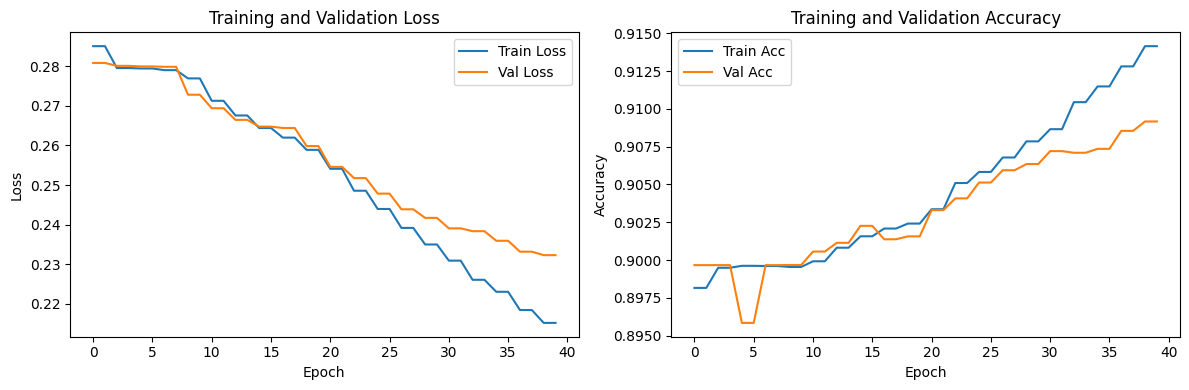

Test Accuracy: 0.9094


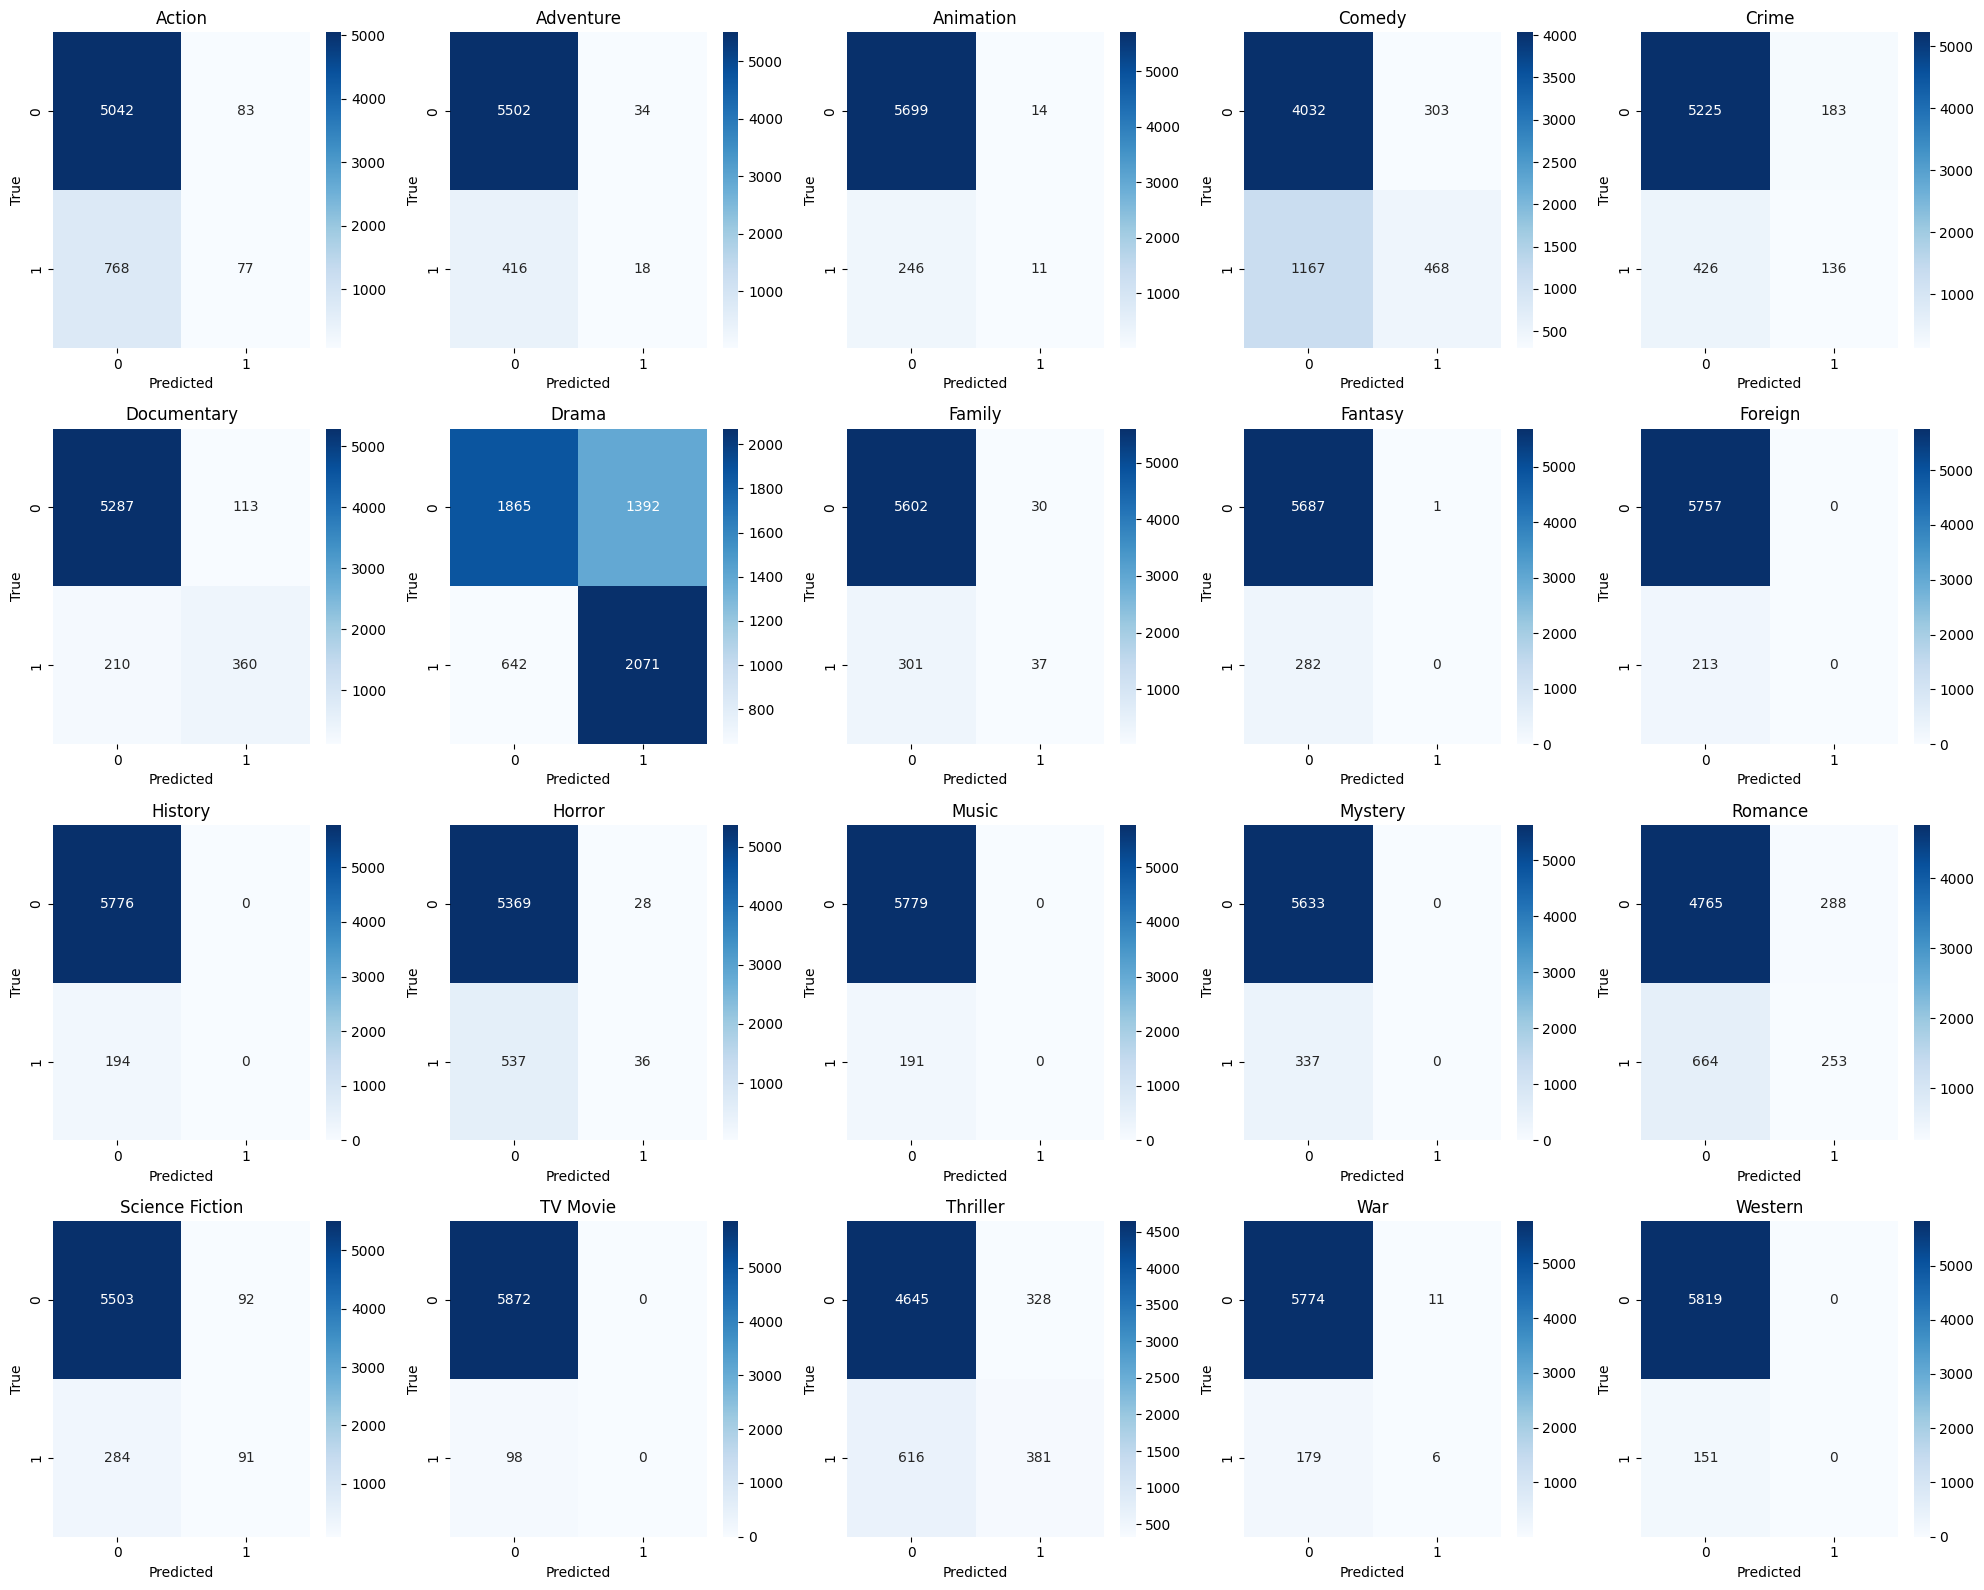

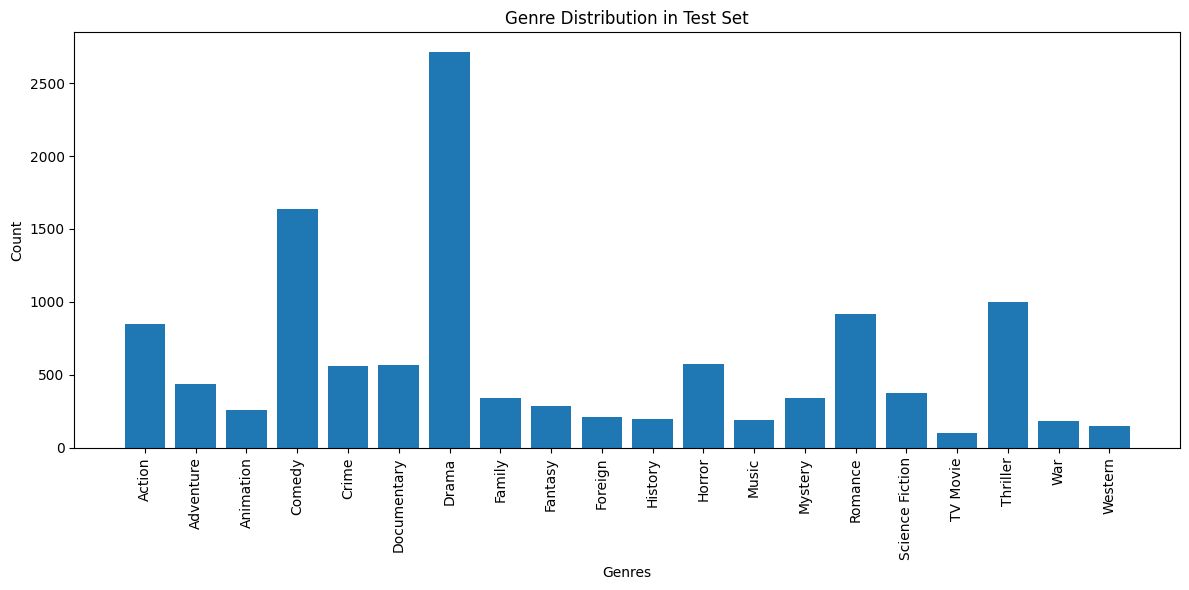

Predicted Genres for new overview: []


In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
import nltk

# Download NLTK data
nltk.download('punkt')

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load and preprocess the data
df = pd.read_csv('filtered_movies.csv', sep='|')
print(f"Dataset size after cleaning: {len(df)} rows")

# Define genres based on the provided distribution
genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 
          'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
print(f"Genres: {genres}")

# Convert genre strings to lists
df['Genre'] = df['Genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Multi-label binarizer for genres
mlb = MultiLabelBinarizer(classes=genres)
genre_labels = mlb.fit_transform(df['Genre'])
print(f"Encoded texts length: {len(genre_labels)}")

# 2. Text preprocessing
def preprocess_text(text):
    if isinstance(text, float) or text is None:
        text = ""
    tokens = word_tokenize(text.lower())
    return tokens

# Tokenize the overview
df['overview_tokens'] = df['Overview'].apply(preprocess_text)

# Build vocabulary
word2idx = {'<PAD>': 0, '<UNK>': 1}
for tokens in df['overview_tokens']:
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = len(word2idx)

# Convert tokens to indices
def tokens_to_indices(tokens, word2idx, max_len=100):
    indices = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    if len(indices) > max_len:
        indices = indices[:max_len]
    else:
        indices += [word2idx['<PAD>']] * (max_len - len(indices))
    return indices

max_len = 100
df['overview_indices'] = df['overview_tokens'].apply(lambda x: tokens_to_indices(x, word2idx, max_len))

# 3. Create PyTorch Dataset
class MovieDataset(Dataset):
    def __init__(self, indices, labels):
        self.indices = indices
        self.labels = labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return torch.tensor(self.indices[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(df['overview_indices'].values, genre_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = MovieDataset(list(X_train), y_train)
val_dataset = MovieDataset(list(X_val), y_val)
test_dataset = MovieDataset(list(X_test), y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# 4. Define the LSTM Model
class GenreClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        dense = self.fc(hidden[-1])
        return torch.sigmoid(dense)

# Model parameters
vocab_size = len(word2idx)
embedding_dim = 100
hidden_dim = 128
output_dim = len(genres)
n_layers = 2
dropout = 0.5

model = GenreClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

# 5. Training Loop
def train_model(model, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0

        for batch_idx, (text, labels) in enumerate(train_loader):
            text, labels = text.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(text)
            
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            # Calculate accuracy (using threshold 0.5)
            predicted = (predictions > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).float().mean().item() * labels.size(0)

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for text, labels in val_loader:
                text, labels = text.to(device), labels.to(device)
                predictions = model(text)
                loss = criterion(predictions, labels)
                val_loss += loss.item()

                predicted = (predictions > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).float().mean().item() * labels.size(0)

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    return train_losses, val_losses, train_accs, val_accs

# Train the model
train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader)

# 6. Plot Training Metrics
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# 7. Evaluate on Test Set
model.eval()
test_correct = 0
test_total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for text, labels in test_loader:
        text, labels = text.to(device), labels.to(device)
        predictions = model(text)
        predicted = (predictions > 0.5).float()
        
        test_total += labels.size(0)
        test_correct += (predicted == labels).float().mean().item() * labels.size(0)
        
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

test_acc = test_correct / test_total
print(f"Test Accuracy: {test_acc:.4f}")

# 8. Confusion Matrix for Each Genre
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.ravel()

for i, genre in enumerate(genres):
    cm = np.zeros((2, 2))
    for j in range(len(all_labels)):
        true_label = int(all_labels[j][i])
        pred_label = int(all_preds[j][i])
        cm[true_label][pred_label] += 1
    
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', ax=axes[i])
    axes[i].set_title(genre)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

# 9. Genre Distribution in Test Set
test_genre_counts = np.sum(all_labels, axis=0)
plt.figure(figsize=(12, 6))
plt.bar(genres, test_genre_counts)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Distribution in Test Set')
plt.tight_layout()
plt.show()

# 10. Example Prediction
def predict_genres(overview, model, word2idx, max_len=100):
    model.eval()
    tokens = preprocess_text(overview)
    indices = tokens_to_indices(tokens, word2idx, max_len)
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    
    with torch.no_grad():
        prediction = model(input_tensor)
        predicted = (prediction > 0.5).float().cpu().numpy()[0]
    
    predicted_genres = [genres[i] for i in range(len(predicted)) if predicted[i] == 1]
    return predicted_genres

# Example usage
new_overview = "A young boy discovers a magical world filled with dragons and knights, embarking on an epic quest to save his family."
predicted_genres = predict_genres(new_overview, model, word2idx)
print(f"Predicted Genres for new overview: {predicted_genres}")

Key Changes in the Updated Code
Weighted Loss: BCEWithLogitsLoss is used with pos_weight to give more weight to the positive class, addressing class imbalance.
F1 Score: Replaced accuracy with F1 score (micro-averaged) to better evaluate performance on imbalanced multi-label data.
Threshold: Lowered the prediction threshold to 0.3 to increase recall for the positive class.
Model Capacity: Increased the embedding size to 200, hidden size to 256, and number of LSTM layers to 3 to improve the model’s ability to capture patterns.
Learning Rate Scheduler: Added a StepLR scheduler to reduce the learning rate every 5 epochs, helping the model converge better.
More Epochs: Increased the number of epochs to 40 to allow the model more time to learn, given the increased capacit

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/kumarsatyam/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kumarsatyam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kumarsatyam/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: mps
Dataset size after cleaning: 39797 rows
Genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Encoded texts length: 39797
Dynamic max_len: 76
Train size: 27857, Val size: 5970, Test size: 5970
Epoch 1: Train Loss: 0.1990, Train Acc: 0.8993, Train Macro F1: 0.0029, Val Loss: 0.1937, Val Acc: 0.9006, Val Macro F1: 0.2142
Epoch 2: Train Loss: 0.1921, Train Acc: 0.9004, Train Macro F1: 0.0110, Val Loss: 0.1904, Val Acc: 0.9005, Val Macro F1: 0.2113
Epoch 3: Train Loss: 0.1847, Train Acc: 0.9010, Train Macro F1: 0.0259, Val Loss: 0.1858, Val Acc: 0.9008, Val Macro F1: 0.2495
Epoch 4: Train Loss: 0.1794, Train Acc: 0.9010, Train Macro F1: 0.0341, Val Loss: 0.1813, Val Acc: 0.9008, Val Macro F1: 0.2629
Epoch 5: Train Loss: 0.1735, Train Acc: 0.9012, Train Macro F1: 0.0438, Val Loss: 0.1763, Val Acc:

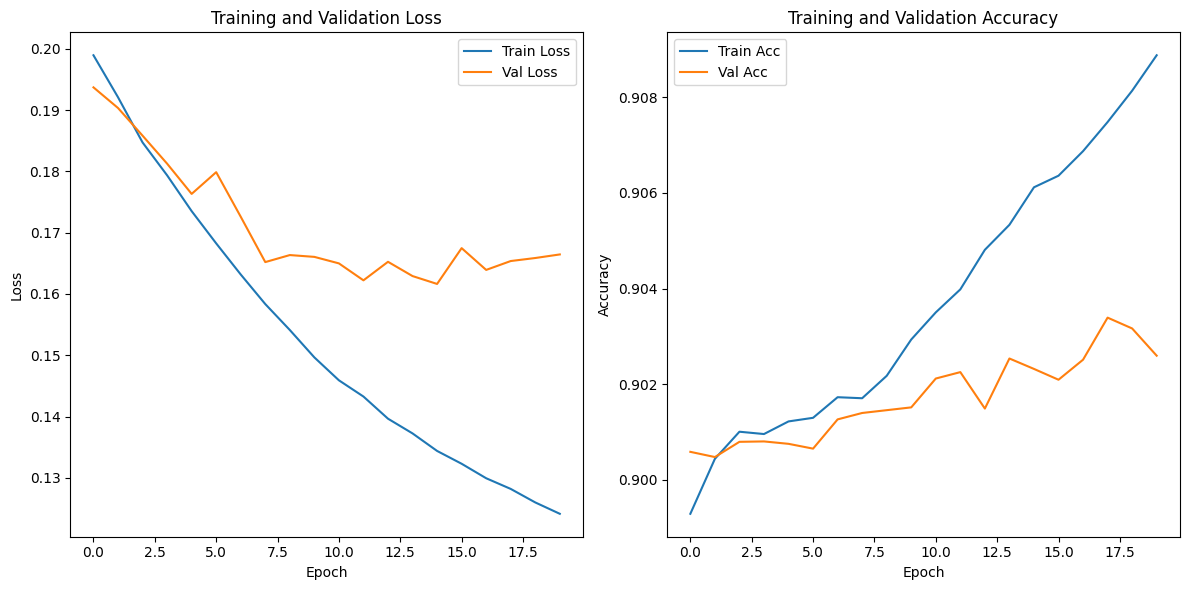

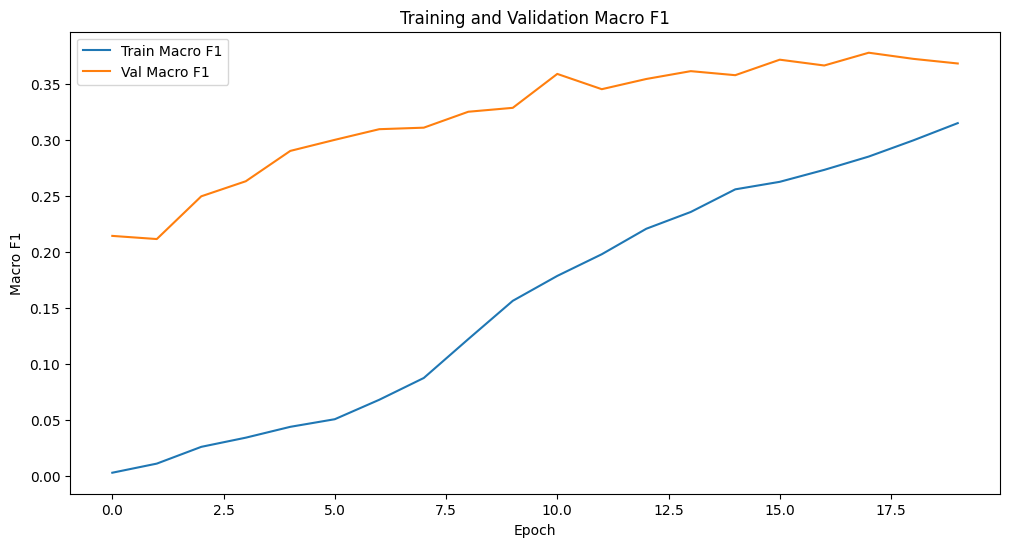

Optimal thresholds per genre: {'Action': np.float32(0.08950438), 'Adventure': np.float32(0.07282151), 'Animation': np.float32(0.3048391), 'Comedy': np.float32(0.059202623), 'Crime': np.float32(0.27812305), 'Documentary': np.float32(0.19372447), 'Drama': np.float32(0.04746997), 'Family': np.float32(0.21557337), 'Fantasy': np.float32(0.114983834), 'Foreign': np.float32(0.045219533), 'History': np.float32(0.26766115), 'Horror': np.float32(0.22824311), 'Music': np.float32(0.54173976), 'Mystery': np.float32(0.15386067), 'Romance': np.float32(0.11942175), 'Science Fiction': np.float32(0.32284048), 'TV Movie': np.float32(0.036123935), 'Thriller': np.float32(0.13654362), 'War': np.float32(0.17056091), 'Western': np.float32(0.61415166)}
Per-genre F1-scores: {'Action': np.float64(0.4664457332228666), 'Adventure': np.float64(0.3294289897510981), 'Animation': np.float64(0.4267241379310345), 'Comedy': np.float64(0.5206779661016949), 'Crime': np.float64(0.47238372093023256), 'Documentary': np.float6

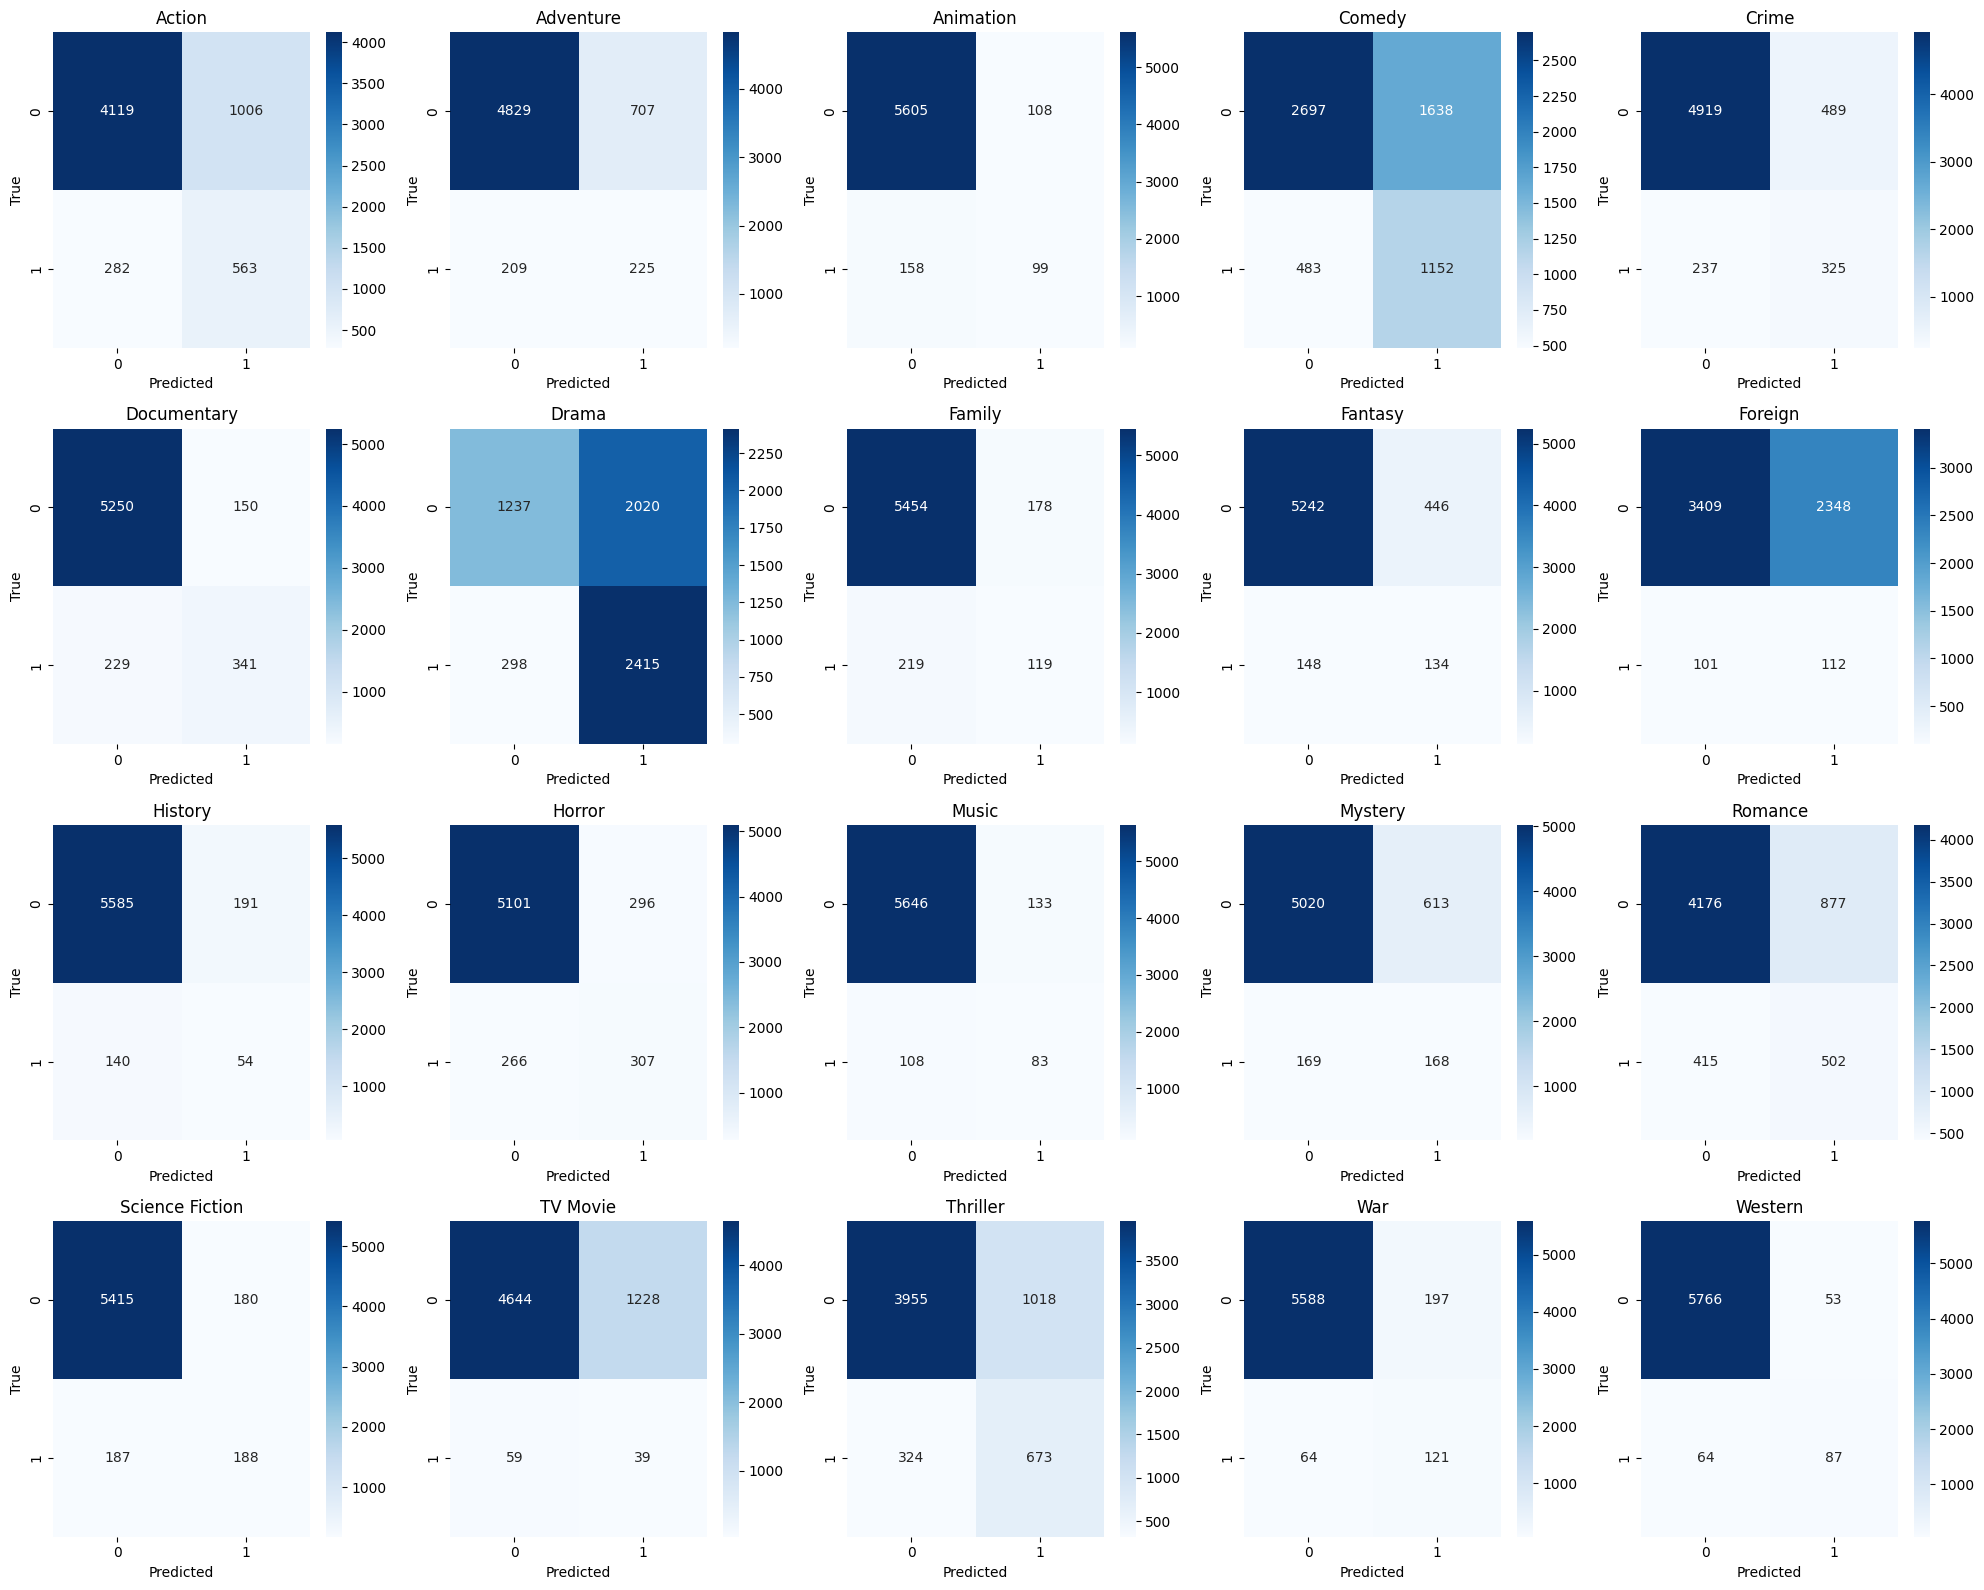

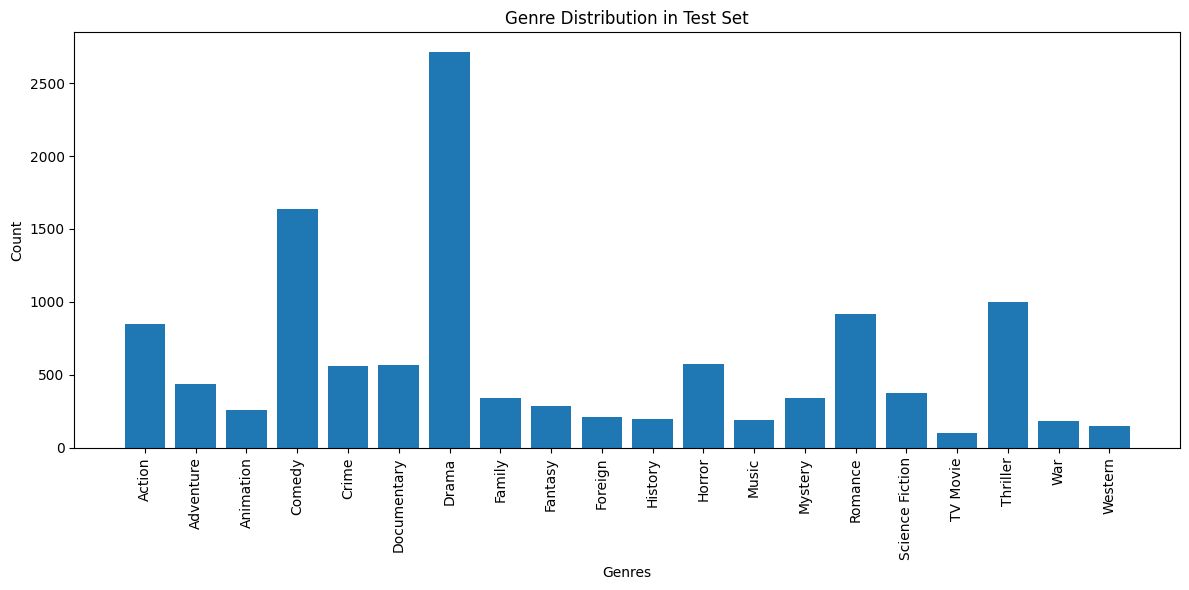

Predicted Genres for new overview: ['Action', 'Adventure', 'Animation', 'Family', 'Fantasy', 'TV Movie']


In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk

# Download NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Set device
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load and preprocess the data
df = pd.read_csv('filtered_movies.csv', sep='|')
print(f"Dataset size after cleaning: {len(df)} rows")

# Define genres
genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 
          'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
print(f"Genres: {genres}")

# Convert genre strings to lists
df['Genre'] = df['Genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Multi-label binarizer for genres
mlb = MultiLabelBinarizer(classes=genres)
genre_labels = mlb.fit_transform(df['Genre'])
print(f"Encoded texts length: {len(genre_labels)}")

# 2. Enhanced Text Preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    if isinstance(text, float) or text is None:
        text = ""
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return tokens

# Tokenize the overview
df['overview_tokens'] = df['Overview'].apply(preprocess_text)

# Build vocabulary
word2idx = {'<PAD>': 0, '<UNK>': 1}
for tokens in df['overview_tokens']:
    for token in tokens:
        if token not in word2idx:
            word2idx[token] = len(word2idx)

# Convert tokens to indices with dynamic max_len
overview_lengths = [len(tokens) for tokens in df['overview_tokens']]
max_len = int(np.percentile(overview_lengths, 90))  # Use 90th percentile for max_len
print(f"Dynamic max_len: {max_len}")

def tokens_to_indices(tokens, word2idx, max_len=max_len):
    indices = [word2idx.get(token, word2idx['<UNK>']) for token in tokens]
    if len(indices) > max_len:
        indices = indices[:max_len]
    else:
        indices += [word2idx['<PAD>']] * (max_len - len(indices))
    return indices

df['overview_indices'] = df['overview_tokens'].apply(lambda x: tokens_to_indices(x, word2idx))

# 3. Create PyTorch Dataset
class MovieDataset(Dataset):
    def __init__(self, indices, labels):
        self.indices = indices
        self.labels = labels

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        return torch.tensor(self.indices[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float)

# Split the data
X_train, X_temp, y_train, y_temp = train_test_split(df['overview_indices'].values, genre_labels, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = MovieDataset(list(X_train), y_train)
val_dataset = MovieDataset(list(X_val), y_val)
test_dataset = MovieDataset(list(X_test), y_test)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# 4. Define the Improved LSTM Model
class GenreClassifier(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, n_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        embedded = self.dropout(self.embedding(text))
        output, (hidden, cell) = self.lstm(embedded)
        hidden = torch.cat((hidden[-2], hidden[-1]), dim=1)  # Concatenate forward and backward hidden states
        dense = self.fc(hidden)
        return dense  # No sigmoid, as we'll use BCEWithLogitsLoss

# Model parameters
vocab_size = len(word2idx)
embedding_dim = 100
hidden_dim = 256
output_dim = len(genres)
n_layers = 3
dropout = 0.5

model = GenreClassifier(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Class-weighted loss
class_counts = np.sum(genre_labels, axis=0)
total_samples = len(genre_labels)
class_weights = torch.tensor(total_samples / (len(genres) * class_counts), dtype=torch.float).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# 5. Training Loop (Modified to Show Both Accuracy and Macro F1)
def train_model(model, train_loader, val_loader, epochs=20):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_f1s, val_f1s = [], []
    best_val_f1 = 0
    patience = 5
    epochs_no_improve = 0
    thresholds = [0.5] * len(genres)  # Initial thresholds

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds, train_labels = [], []

        for batch_idx, (text, labels) in enumerate(train_loader):
            text, labels = text.to(device), labels.to(device)
            optimizer.zero_grad()
            predictions = model(text)
            
            loss = criterion(predictions, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            
            # Calculate accuracy (using threshold 0.5)
            predicted = (torch.sigmoid(predictions) > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).float().mean().item() * labels.size(0)
            train_preds.append(predicted.cpu().numpy())
            train_labels.append(labels.cpu().numpy())

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_preds = np.vstack(train_preds)
        train_labels = np.vstack(train_labels)
        train_f1 = f1_score(train_labels, train_preds, average='macro')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for text, labels in val_loader:
                text, labels = text.to(device), labels.to(device)
                predictions = model(text)
                loss = criterion(predictions, labels)
                val_loss += loss.item()

                # Calculate accuracy (using threshold 0.5 for display)
                predicted = (torch.sigmoid(predictions) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).float().mean().item() * labels.size(0)
                val_preds.append(torch.sigmoid(predictions).cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        # Compute thresholds after first epoch
        val_preds = np.vstack(val_preds)
        val_labels = np.vstack(val_labels)
        if epoch == 0:
            thresholds = []
            for i in range(len(genres)):
                precision, recall, thresh = precision_recall_curve(val_labels[:, i], val_preds[:, i])
                f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
                optimal_idx = np.argmax(f1_scores)
                thresholds.append(thresh[optimal_idx] if optimal_idx < len(thresh) else 0.5)

        # Apply per-genre thresholds for F1-score calculation
        val_preds_adjusted = np.zeros_like(val_preds)
        for i in range(len(genres)):
            val_preds_adjusted[:, i] = (val_preds[:, i] > thresholds[i]).astype(float)
        
        val_f1 = f1_score(val_labels, val_preds_adjusted, average='macro')
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Macro F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Macro F1: {val_f1:.4f}")

        # Early stopping based on macro F1-score
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s

# Train the model
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s = train_model(model, train_loader, val_loader)

# 6. Plot Training Metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot F1-scores
plt.figure(figsize=(12, 6))
plt.plot(train_f1s, label='Train Macro F1')
plt.plot(val_f1s, label='Val Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.title('Training and Validation Macro F1')
plt.legend()
plt.show()

# 7. Compute Optimal Thresholds on Validation Set
model.eval()
val_preds, val_labels = [], []
with torch.no_grad():
    for text, labels in val_loader:
        text, labels = text.to(device), labels.to(device)
        predictions = model(text)
        val_preds.append(torch.sigmoid(predictions).cpu().numpy())
        val_labels.append(labels.cpu().numpy())

val_preds = np.vstack(val_preds)
val_labels = np.vstack(val_labels)

thresholds = []
for i in range(len(genres)):
    precision, recall, thresh = precision_recall_curve(val_labels[:, i], val_preds[:, i])
    f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
    optimal_idx = np.argmax(f1_scores)
    thresholds.append(thresh[optimal_idx] if optimal_idx < len(thresh) else 0.5)
print(f"Optimal thresholds per genre: {dict(zip(genres, thresholds))}")

# 8. Evaluate on Test Set with Optimal Thresholds
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for text, labels in test_loader:
        text, labels = text.to(device), labels.to(device)
        predictions = model(text)
        test_preds.append(torch.sigmoid(predictions).cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)

# Apply per-genre thresholds
test_preds_adjusted = np.zeros_like(test_preds)
for i in range(len(genres)):
    test_preds_adjusted[:, i] = (test_preds[:, i] > thresholds[i]).astype(float)

# Compute F1-scores
f1_scores = f1_score(test_labels, test_preds_adjusted, average=None)
macro_f1 = f1_score(test_labels, test_preds_adjusted, average='macro')
print(f"Per-genre F1-scores: {dict(zip(genres, f1_scores))}")
print(f"Test Macro-averaged F1-score: {macro_f1:.4f}")

# 9. Confusion Matrix for Each Genre
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.ravel()

for i, genre in enumerate(genres):
    cm = np.zeros((2, 2))
    for j in range(len(test_labels)):
        true_label = int(test_labels[j][i])
        pred_label = int(test_preds_adjusted[j][i])
        cm[true_label][pred_label] += 1
    
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', ax=axes[i])
    axes[i].set_title(genre)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

# 10. Genre Distribution in Test Set
test_genre_counts = np.sum(test_labels, axis=0)
plt.figure(figsize=(12, 6))
plt.bar(genres, test_genre_counts)
plt.xticks(rotation=90)
plt.xlabel('Genres')
plt.ylabel('Count')
plt.title('Genre Distribution in Test Set')
plt.tight_layout()
plt.show()

# 11. Example Prediction
def predict_genres(overview, model, word2idx, max_len=max_len, thresholds=thresholds):
    model.eval()
    tokens = preprocess_text(overview)
    indices = tokens_to_indices(tokens, word2idx, max_len)
    input_tensor = torch.tensor([indices], dtype=torch.long).to(device)
    
    with torch.no_grad():
        prediction = model(input_tensor)
        prediction = torch.sigmoid(prediction).cpu().numpy()[0]
    
    predicted = np.zeros_like(prediction)
    for i in range(len(genres)):
        predicted[i] = 1 if prediction[i] > thresholds[i] else 0
    predicted_genres = [genres[i] for i in range(len(predicted)) if predicted[i] == 1]
    return predicted_genres

# Example usage
new_overview = "A young boy discovers a magical world filled with dragons and knights, embarking on an epic quest to save his family."
predicted_genres = predict_genres(new_overview, model, word2idx)
print(f"Predicted Genres for new overview: {predicted_genres}")

use bert

Using device: mps
Dataset size after cleaning: 39797 rows
Genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Encoded texts length: 39797
Train size: 43669, Val size: 9358, Test size: 9358


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/kumarsatyam/python/basicsofai/project/.venv/lib/python3.9/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1 Validation: 100%|██████████| 585/585 [04:05<00:00,  2.39it/s]


Epoch 1: Train Loss: 0.0149, Train Acc: 0.9100, Train Macro F1: 0.5253, Val Loss: 0.0126, Val Acc: 0.9226, Val Macro F1: 0.6469
Per-genre Val F1-scores: {'Action': np.float64(0.6196319018404908), 'Adventure': np.float64(0.5573609059576563), 'Animation': np.float64(0.7157057654075547), 'Comedy': np.float64(0.6669185716984697), 'Crime': np.float64(0.5599022004889975), 'Documentary': np.float64(0.8056112224448898), 'Drama': np.float64(0.751875), 'Family': np.float64(0.6873994638069705), 'Fantasy': np.float64(0.5951807228915663), 'Foreign': np.float64(0.3310276679841897), 'History': np.float64(0.6290883785664579), 'Horror': np.float64(0.6967741935483871), 'Music': np.float64(0.6993006993006993), 'Mystery': np.float64(0.5178082191780822), 'Romance': np.float64(0.5771594953089615), 'Science Fiction': np.float64(0.7287917737789203), 'TV Movie': np.float64(0.4907325684024713), 'Thriller': np.float64(0.6006042296072508), 'War': np.float64(0.7735139202407826), 'Western': np.float64(0.93288020390

Epoch 2 Validation: 100%|██████████| 585/585 [03:54<00:00,  2.50it/s]


Epoch 2: Train Loss: 0.0114, Train Acc: 0.9292, Train Macro F1: 0.6669, Val Loss: 0.0108, Val Acc: 0.9332, Val Macro F1: 0.7003
Per-genre Val F1-scores: {'Action': np.float64(0.6535229476405947), 'Adventure': np.float64(0.6120416478044364), 'Animation': np.float64(0.7702786377708978), 'Comedy': np.float64(0.7085866261398176), 'Crime': np.float64(0.5605095541401274), 'Documentary': np.float64(0.8344733242134063), 'Drama': np.float64(0.7724240177909563), 'Family': np.float64(0.7310182460270748), 'Fantasy': np.float64(0.6646489104116223), 'Foreign': np.float64(0.4316455696202532), 'History': np.float64(0.6673717609730302), 'Horror': np.float64(0.7193229901269393), 'Music': np.float64(0.7671480144404332), 'Mystery': np.float64(0.5737817433081674), 'Romance': np.float64(0.6087252897068848), 'Science Fiction': np.float64(0.7709279688513953), 'TV Movie': np.float64(0.7660586835844568), 'Thriller': np.float64(0.6189789443322757), 'War': np.float64(0.8176555716353111), 'Western': np.float64(0.9

Epoch 3 Validation: 100%|██████████| 585/585 [04:08<00:00,  2.36it/s]


Epoch 3: Train Loss: 0.0091, Train Acc: 0.9444, Train Macro F1: 0.7491, Val Loss: 0.0099, Val Acc: 0.9426, Val Macro F1: 0.7372
Per-genre Val F1-scores: {'Action': np.float64(0.7120078099576961), 'Adventure': np.float64(0.6755392381826526), 'Animation': np.float64(0.8365320979483786), 'Comedy': np.float64(0.7370276091638926), 'Crime': np.float64(0.5985401459854015), 'Documentary': np.float64(0.8443271767810027), 'Drama': np.float64(0.7866694095865049), 'Family': np.float64(0.7883040935672515), 'Fantasy': np.float64(0.6979569298729983), 'Foreign': np.float64(0.4787018255578093), 'History': np.float64(0.6891891891891891), 'Horror': np.float64(0.7412755716004813), 'Music': np.float64(0.8051529790660226), 'Mystery': np.float64(0.5871848739495799), 'Romance': np.float64(0.6347340581839553), 'Science Fiction': np.float64(0.8193508879363135), 'TV Movie': np.float64(0.8151862464183381), 'Thriller': np.float64(0.6371223021582734), 'War': np.float64(0.8897168405365127), 'Western': np.float64(0.9

Epoch 4 Validation: 100%|██████████| 585/585 [04:04<00:00,  2.39it/s]


Epoch 4: Train Loss: 0.0071, Train Acc: 0.9575, Train Macro F1: 0.8099, Val Loss: 0.0093, Val Acc: 0.9499, Val Macro F1: 0.7747
Per-genre Val F1-scores: {'Action': np.float64(0.7449078564500485), 'Adventure': np.float64(0.7577184720041863), 'Animation': np.float64(0.8701986754966887), 'Comedy': np.float64(0.7609492571869574), 'Crime': np.float64(0.5975359342915811), 'Documentary': np.float64(0.8415147265077139), 'Drama': np.float64(0.800376254180602), 'Family': np.float64(0.837588267246062), 'Fantasy': np.float64(0.7304537998906506), 'Foreign': np.float64(0.6146788990825688), 'History': np.float64(0.779837775202781), 'Horror': np.float64(0.7762733720180529), 'Music': np.float64(0.8561872909698997), 'Mystery': np.float64(0.64), 'Romance': np.float64(0.66624), 'Science Fiction': np.float64(0.847247990105133), 'TV Movie': np.float64(0.832378223495702), 'Thriller': np.float64(0.6639751552795031), 'War': np.float64(0.9073243647234679), 'Western': np.float64(0.9682274247491639)}


Epoch 5 Validation: 100%|██████████| 585/585 [03:52<00:00,  2.51it/s]


Epoch 5: Train Loss: 0.0055, Train Acc: 0.9680, Train Macro F1: 0.8566, Val Loss: 0.0094, Val Acc: 0.9542, Val Macro F1: 0.8054
Per-genre Val F1-scores: {'Action': np.float64(0.7891483516483516), 'Adventure': np.float64(0.7895310796074155), 'Animation': np.float64(0.883289124668435), 'Comedy': np.float64(0.7546276366767112), 'Crime': np.float64(0.5980135912179823), 'Documentary': np.float64(0.8394004282655246), 'Drama': np.float64(0.812211498111624), 'Family': np.float64(0.8505997818974919), 'Fantasy': np.float64(0.8101879927228623), 'Foreign': np.float64(0.701123595505618), 'History': np.float64(0.8587641866330391), 'Horror': np.float64(0.7785760940561725), 'Music': np.float64(0.8660640920295809), 'Mystery': np.float64(0.7175792507204611), 'Romance': np.float64(0.7002081887578071), 'Science Fiction': np.float64(0.8720379146919431), 'TV Movie': np.float64(0.9351701782820098), 'Thriller': np.float64(0.6723973256924546), 'War': np.float64(0.9161098737936154), 'Western': np.float64(0.9627

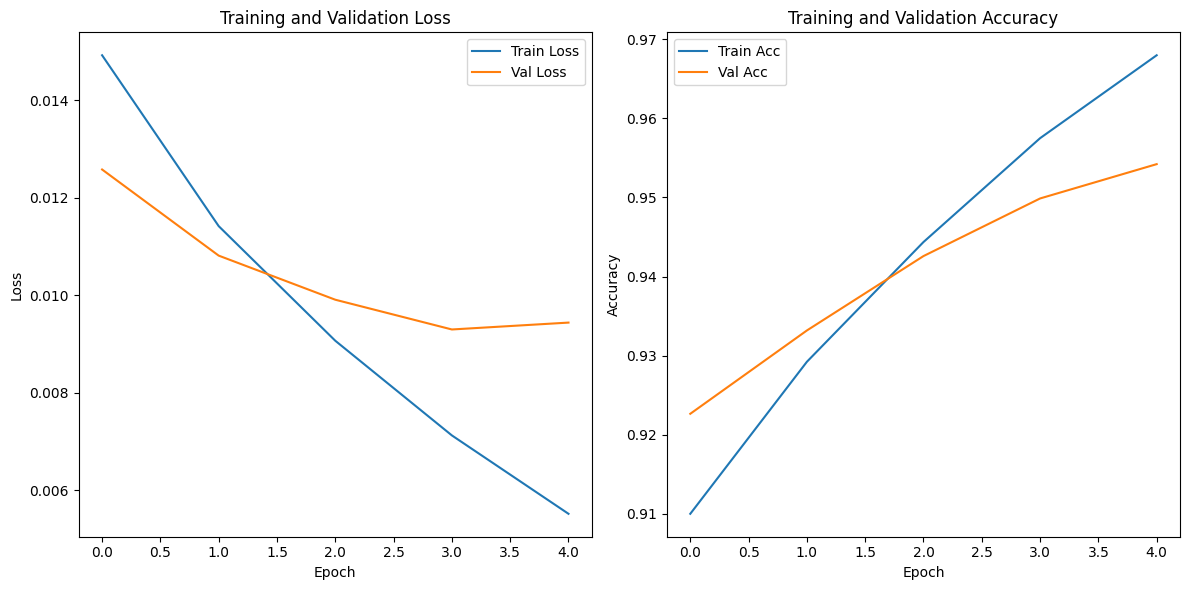

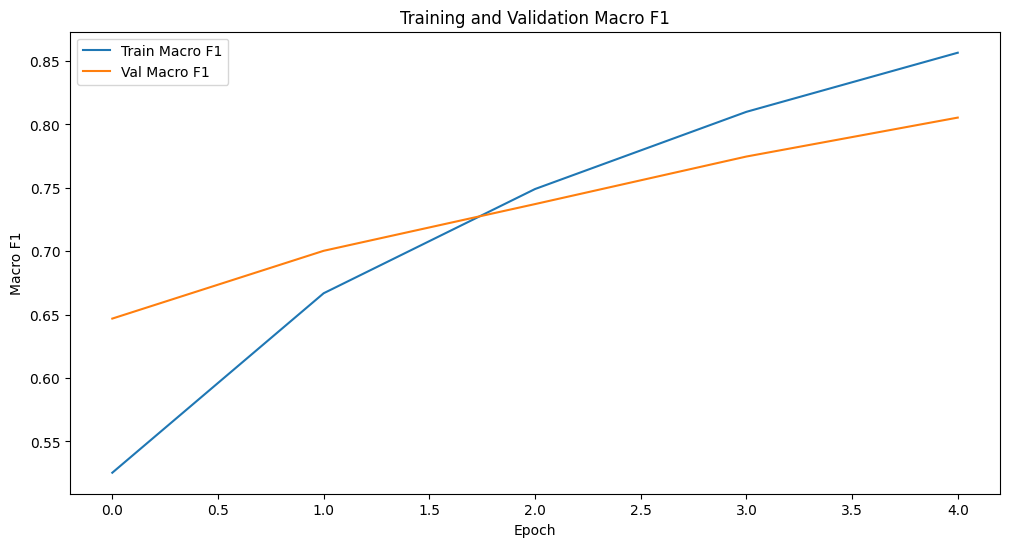

Optimal thresholds per genre: {'Action': np.float32(0.45513076), 'Adventure': np.float32(0.41889948), 'Animation': np.float32(0.40272805), 'Comedy': np.float32(0.4036468), 'Crime': np.float32(0.37560987), 'Documentary': np.float32(0.5248987), 'Drama': np.float32(0.4314387), 'Family': np.float32(0.48987198), 'Fantasy': np.float32(0.3802955), 'Foreign': np.float32(0.33922794), 'History': np.float32(0.34901014), 'Horror': np.float32(0.46910647), 'Music': np.float32(0.4015057), 'Mystery': np.float32(0.38378942), 'Romance': np.float32(0.41223788), 'Science Fiction': np.float32(0.4607098), 'TV Movie': np.float32(0.4174479), 'Thriller': np.float32(0.42991182), 'War': np.float32(0.42357543), 'Western': np.float32(0.41480687)}
Per-genre Test F1-scores: {'Action': np.float64(0.7961826857532379), 'Adventure': np.float64(0.7959067652075043), 'Animation': np.float64(0.8953020134228188), 'Comedy': np.float64(0.7559616670381101), 'Crime': np.float64(0.5977260422306443), 'Documentary': np.float64(0.85

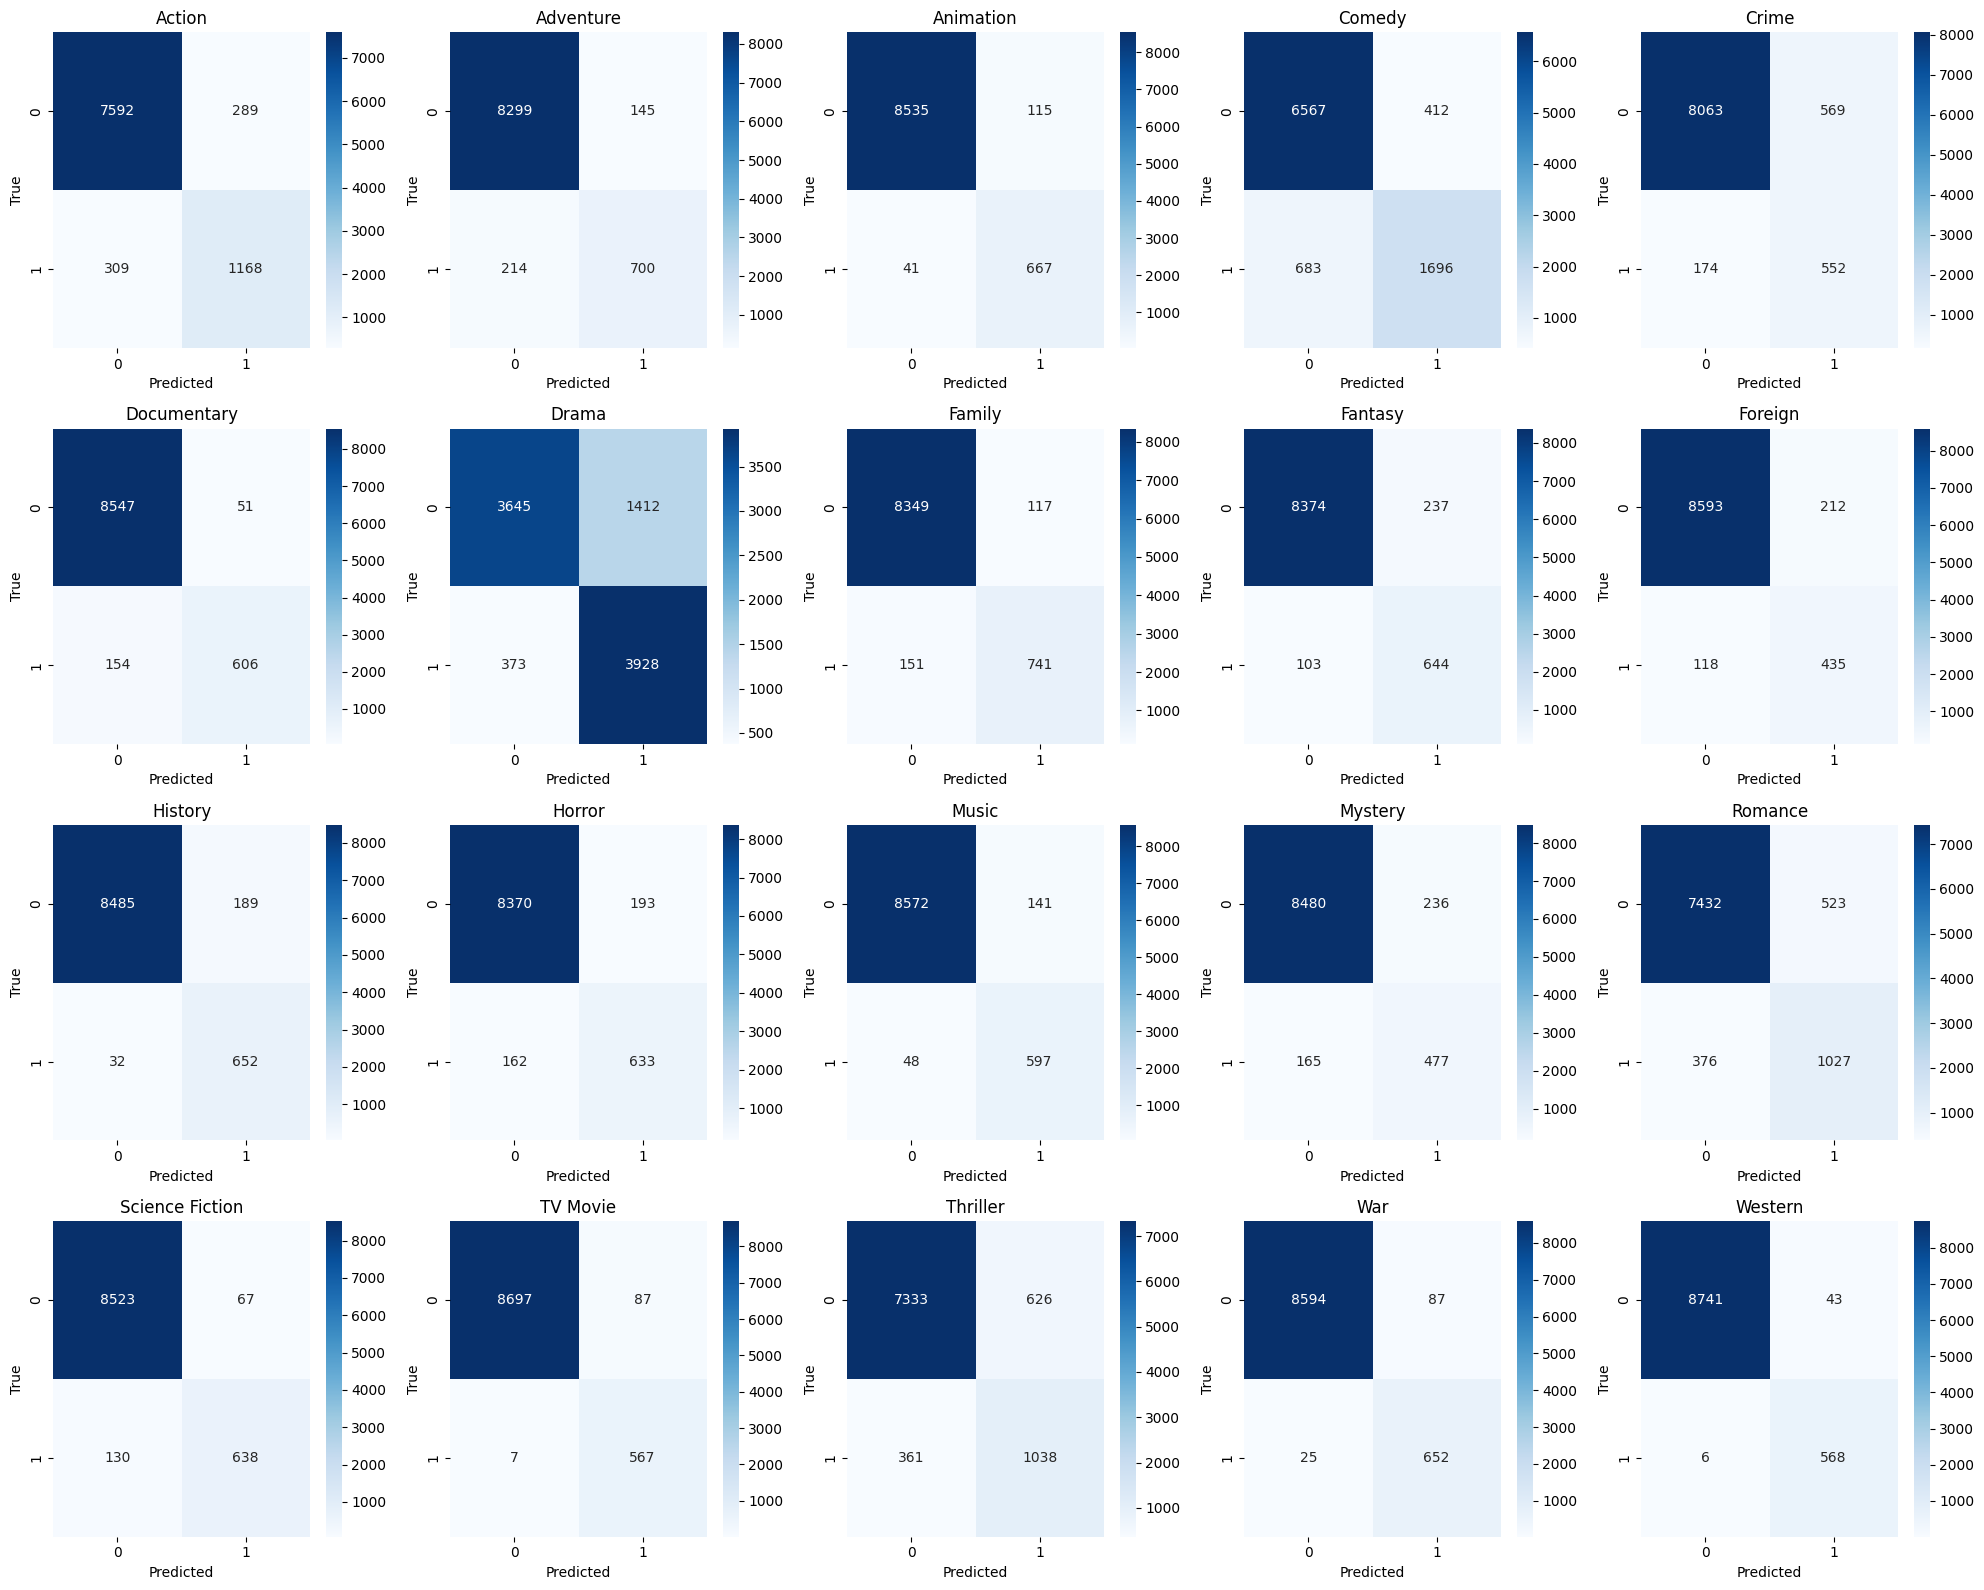

In [14]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load and preprocess the data
df = pd.read_csv('filtered_movies.csv', sep='|')
print(f"Dataset size after cleaning: {len(df)} rows")

# Define genres
genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 
          'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
print(f"Genres: {genres}")

# Convert genre strings to lists
df['Genre'] = df['Genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Multi-label binarizer for genres
mlb = MultiLabelBinarizer(classes=genres)
genre_labels = mlb.fit_transform(df['Genre'])
print(f"Encoded texts length: {len(genre_labels)}")

# 2. Load BERT Tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
max_len = 128

def tokenize_text(text):
    if isinstance(text, float) or text is None:
        text = ""
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze()

# Tokenize the overviews
df['encoded'] = df['Overview'].apply(tokenize_text)

# Custom multi-label oversampling
encoded_np = np.array(df['encoded'].tolist())
genre_labels_np = np.array(genre_labels)

# Compute the frequency of each genre
genre_counts = np.sum(genre_labels_np, axis=0)
target_count = int(np.median(genre_counts) * 1.5)  # Target count for each genre (1.5x median)

# Oversample each genre independently
oversampled_indices = []
for genre_idx in range(len(genres)):
    # Find indices where this genre is present
    genre_indices = np.where(genre_labels_np[:, genre_idx] == 1)[0]
    current_count = len(genre_indices)
    
    if current_count == 0:
        continue  # Skip if no examples for this genre
    
    # If the genre is underrepresented, oversample
    if current_count < target_count:
        oversample_size = target_count - current_count
        # Randomly sample indices with replacement
        oversampled_genre_indices = np.random.choice(genre_indices, size=oversample_size, replace=True)
        oversampled_indices.extend(oversampled_genre_indices)

# Combine original indices with oversampled indices
all_indices = np.arange(len(encoded_np)).tolist() + oversampled_indices
encoded_resampled = encoded_np[all_indices]
genre_labels_resampled = genre_labels_np[all_indices]

# 3. Create PyTorch Dataset
class MovieDataset(Dataset):
    def __init__(self, encoded, labels):
        self.input_ids = [enc[0] for enc in encoded]
        self.attention_masks = [enc[1] for enc in encoded]
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Split the resampled data
X_train, X_temp, y_train, y_temp = train_test_split(encoded_resampled, genre_labels_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = MovieDataset(X_train, y_train)
val_dataset = MovieDataset(X_val, y_val)
test_dataset = MovieDataset(X_test, y_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# 4. Load BERT Model
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(genres),
    problem_type="multi_label_classification"
).to(device)

# Freeze early layers to focus on genre-specific features
for param in model.bert.encoder.layer[:6].parameters():
    param.requires_grad = False

optimizer = AdamW(model.parameters(), lr=2e-5)

# 5. Define Focal Loss
def focal_loss(logits, labels, alpha=0.25, gamma=2):
    bce_loss = nn.BCEWithLogitsLoss(reduction='none')(logits, labels)
    pt = torch.exp(-bce_loss)
    focal_loss = alpha * (1 - pt) ** gamma * bce_loss
    return focal_loss.mean()

# 6. Training Loop with Focal Loss and Adjusted Thresholds
def train_model(model, train_loader, val_loader, epochs=5):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_f1s, val_f1s = [], []
    best_val_f1 = 0
    patience = 3
    epochs_no_improve = 0
    thresholds = [0.5] * len(genres)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds, train_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            # Use focal loss
            loss = focal_loss(logits, labels, alpha=0.25, gamma=2)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (torch.sigmoid(logits) > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).float().mean().item() * labels.size(0)
            train_preds.append(torch.sigmoid(logits).detach().cpu().numpy())
            train_labels.append(labels.cpu().numpy())

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_preds = np.vstack(train_preds)
        train_labels = np.vstack(train_labels)

        # Compute thresholds after first epoch (with bias for rare genres)
        if epoch == 0:
            val_preds, val_labels = [], []
            model.eval()
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask)
                    logits = outputs.logits
                    val_preds.append(torch.sigmoid(logits).cpu().numpy())
                    val_labels.append(labels.cpu().numpy())
            val_preds = np.vstack(val_preds)
            val_labels = np.vstack(val_labels)
            class_counts = np.sum(genre_labels_resampled, axis=0)
            thresholds = []
            for i in range(len(genres)):
                precision, recall, thresh = precision_recall_curve(val_labels[:, i], val_preds[:, i])
                f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
                # Bias towards higher precision for rare genres
                if class_counts[i] < 500:
                    optimal_idx = np.argmax(precision * 0.7 + recall * 0.3)
                else:
                    optimal_idx = np.argmax(f1_scores)
                thresholds.append(thresh[optimal_idx] if optimal_idx < len(thresh) else 0.5)

        # Apply per-genre thresholds for training F1-score
        train_preds_adjusted = np.zeros_like(train_preds)
        for i in range(len(genres)):
            train_preds_adjusted[:, i] = (train_preds[:, i] > thresholds[i]).astype(float)
        train_f1 = f1_score(train_labels, train_preds_adjusted, average='macro')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = focal_loss(logits, labels, alpha=0.25, gamma=2)
                val_loss += loss.item()

                predicted = (torch.sigmoid(logits) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).float().mean().item() * labels.size(0)
                val_preds.append(torch.sigmoid(logits).cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        val_preds = np.vstack(val_preds)
        val_labels = np.vstack(val_labels)
        val_preds_adjusted = np.zeros_like(val_preds)
        for i in range(len(genres)):
            val_preds_adjusted[:, i] = (val_preds[:, i] > thresholds[i]).astype(float)
        
        val_f1 = f1_score(val_labels, val_preds_adjusted, average='macro')
        val_f1_per_genre = f1_score(val_labels, val_preds_adjusted, average=None)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Macro F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Macro F1: {val_f1:.4f}")
        print(f"Per-genre Val F1-scores: {dict(zip(genres, val_f1_per_genre))}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s, thresholds

# Train the model with the fixes
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s, thresholds = train_model(model, train_loader, val_loader)

# 7. Plot Training Metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot F1-scores
plt.figure(figsize=(12, 6))
plt.plot(train_f1s, label='Train Macro F1')
plt.plot(val_f1s, label='Val Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.title('Training and Validation Macro F1')
plt.legend()
plt.show()

# 8. Print Optimal Thresholds
print(f"Optimal thresholds per genre: {dict(zip(genres, thresholds))}")

# 9. Evaluate on Test Set with Optimal Thresholds
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        test_preds.append(torch.sigmoid(logits).cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)

test_preds_adjusted = np.zeros_like(test_preds)
for i in range(len(genres)):
    test_preds_adjusted[:, i] = (test_preds[:, i] > thresholds[i]).astype(float)

f1_scores = f1_score(test_labels, test_preds_adjusted, average=None)
macro_f1 = f1_score(test_labels, test_preds_adjusted, average='macro')
print(f"Per-genre Test F1-scores: {dict(zip(genres, f1_scores))}")
print(f"Test Macro-averaged F1-score: {macro_f1:.4f}")

# 10. Confusion Matrix for Each Genre
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.ravel()

for i, genre in enumerate(genres):
    cm = np.zeros((2, 2))
    for j in range(len(test_labels)):
        true_label = int(test_labels[j][i])
        pred_label = int(test_preds_adjusted[j][i])
        cm[true_label][pred_label] += 1
    
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', ax=axes[i])
    axes[i].set_title(genre)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

GPT MODEL


Using device: mps
Dataset size after cleaning: 39797 rows
Genres: ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
Encoded texts length: 39797
Train size: 43669, Val size: 9358, Test size: 9358


Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/Users/kumarsatyam/python/basicsofai/project/.venv/lib/python3.9/site-packages/transformers/optimization.py:640: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
Epoch 1 Validation: 100%|██████████| 585/585 [05:05<00:00,  1.91it/s]


Epoch 1: Train Loss: 0.0233, Train Acc: 0.8788, Train Macro F1: 0.2851, Val Loss: 0.0157, Val Acc: 0.9033, Val Macro F1: 0.5324
Per-genre Val F1-scores: {'Action': np.float64(0.5405552531301034), 'Adventure': np.float64(0.45983133599644915), 'Animation': np.float64(0.5403170227429359), 'Comedy': np.float64(0.5960108181203516), 'Crime': np.float64(0.494091164884637), 'Documentary': np.float64(0.687960687960688), 'Drama': np.float64(0.6974563591022443), 'Family': np.float64(0.5489773950484392), 'Fantasy': np.float64(0.4918238993710692), 'Foreign': np.float64(0.23900789177001128), 'History': np.float64(0.501611863313991), 'Horror': np.float64(0.566383257030739), 'Music': np.float64(0.5766871165644172), 'Mystery': np.float64(0.4012772751463544), 'Romance': np.float64(0.475445730372224), 'Science Fiction': np.float64(0.6275331935709294), 'TV Movie': np.float64(0.2609308885754584), 'Thriller': np.float64(0.5528146742567995), 'War': np.float64(0.6767757382282522), 'Western': np.float64(0.7116

Epoch 2 Validation: 100%|██████████| 585/585 [06:29<00:00,  1.50it/s]


Epoch 2: Train Loss: 0.0150, Train Acc: 0.9088, Train Macro F1: 0.5261, Val Loss: 0.0142, Val Acc: 0.9126, Val Macro F1: 0.5699
Per-genre Val F1-scores: {'Action': np.float64(0.5807702964810196), 'Adventure': np.float64(0.49167482859941236), 'Animation': np.float64(0.5908726981585268), 'Comedy': np.float64(0.6222147763444463), 'Crime': np.float64(0.5148729042725798), 'Documentary': np.float64(0.7154929577464789), 'Drama': np.float64(0.7198879551820728), 'Family': np.float64(0.6062789500772002), 'Fantasy': np.float64(0.4704875962360992), 'Foreign': np.float64(0.2844638949671772), 'History': np.float64(0.510351966873706), 'Horror': np.float64(0.6178643384822028), 'Music': np.float64(0.6109022556390977), 'Mystery': np.float64(0.47072879330943845), 'Romance': np.float64(0.5241779497098646), 'Science Fiction': np.float64(0.6624022743425728), 'TV Movie': np.float64(0.3642611683848797), 'Thriller': np.float64(0.570142015933495), 'War': np.float64(0.7206537890044576), 'Western': np.float64(0.7

Epoch 3 Validation: 100%|██████████| 585/585 [06:40<00:00,  1.46it/s]


Epoch 3: Train Loss: 0.0137, Train Acc: 0.9152, Train Macro F1: 0.5720, Val Loss: 0.0133, Val Acc: 0.9176, Val Macro F1: 0.6030
Per-genre Val F1-scores: {'Action': np.float64(0.5687514640431014), 'Adventure': np.float64(0.5050798258345428), 'Animation': np.float64(0.6599221789883268), 'Comedy': np.float64(0.6386315039201711), 'Crime': np.float64(0.5270108043217286), 'Documentary': np.float64(0.751653638003608), 'Drama': np.float64(0.7331843575418995), 'Family': np.float64(0.5938069216757741), 'Fantasy': np.float64(0.551772063933287), 'Foreign': np.float64(0.30761572921851665), 'History': np.float64(0.5838187702265372), 'Horror': np.float64(0.6474530831099196), 'Music': np.float64(0.6357738646895273), 'Mystery': np.float64(0.49645390070921985), 'Romance': np.float64(0.5486037469070343), 'Science Fiction': np.float64(0.7015851137146796), 'TV Movie': np.float64(0.4560639070442992), 'Thriller': np.float64(0.5929411764705882), 'War': np.float64(0.7329842931937173), 'Western': np.float64(0.8

Epoch 4 Validation: 100%|██████████| 585/585 [05:59<00:00,  1.63it/s]


Epoch 4: Train Loss: 0.0128, Train Acc: 0.9205, Train Macro F1: 0.6058, Val Loss: 0.0127, Val Acc: 0.9218, Val Macro F1: 0.6250
Per-genre Val F1-scores: {'Action': np.float64(0.5932244699000732), 'Adventure': np.float64(0.5290566037735849), 'Animation': np.float64(0.7071524966261808), 'Comedy': np.float64(0.6457658885670472), 'Crime': np.float64(0.5347313237221494), 'Documentary': np.float64(0.7756703727926749), 'Drama': np.float64(0.725137614678899), 'Family': np.float64(0.6183970856102003), 'Fantasy': np.float64(0.5847408270238789), 'Foreign': np.float64(0.3436293436293436), 'History': np.float64(0.6321626617375231), 'Horror': np.float64(0.6750599520383693), 'Music': np.float64(0.6620450606585788), 'Mystery': np.float64(0.5267433987813135), 'Romance': np.float64(0.5372670807453416), 'Science Fiction': np.float64(0.6975857687420585), 'TV Movie': np.float64(0.5477621910487642), 'Thriller': np.float64(0.6102893890675242), 'War': np.float64(0.7674418604651163), 'Western': np.float64(0.78

Epoch 5 Validation: 100%|██████████| 585/585 [04:34<00:00,  2.13it/s]


Epoch 5: Train Loss: 0.0119, Train Acc: 0.9257, Train Macro F1: 0.6400, Val Loss: 0.0120, Val Acc: 0.9263, Val Macro F1: 0.6487
Per-genre Val F1-scores: {'Action': np.float64(0.6159244264507422), 'Adventure': np.float64(0.5764499121265377), 'Animation': np.float64(0.746268656716418), 'Comedy': np.float64(0.6637261820748059), 'Crime': np.float64(0.5460048426150121), 'Documentary': np.float64(0.7801857585139319), 'Drama': np.float64(0.7445086705202312), 'Family': np.float64(0.6652631578947369), 'Fantasy': np.float64(0.5956989247311828), 'Foreign': np.float64(0.35485287659200704), 'History': np.float64(0.6599749058971142), 'Horror': np.float64(0.6435233160621762), 'Music': np.float64(0.6763990267639902), 'Mystery': np.float64(0.5179856115107914), 'Romance': np.float64(0.5655070318282753), 'Science Fiction': np.float64(0.723693143245078), 'TV Movie': np.float64(0.6293622141997594), 'Thriller': np.float64(0.6230012300123001), 'War': np.float64(0.7901639344262295), 'Western': np.float64(0.85

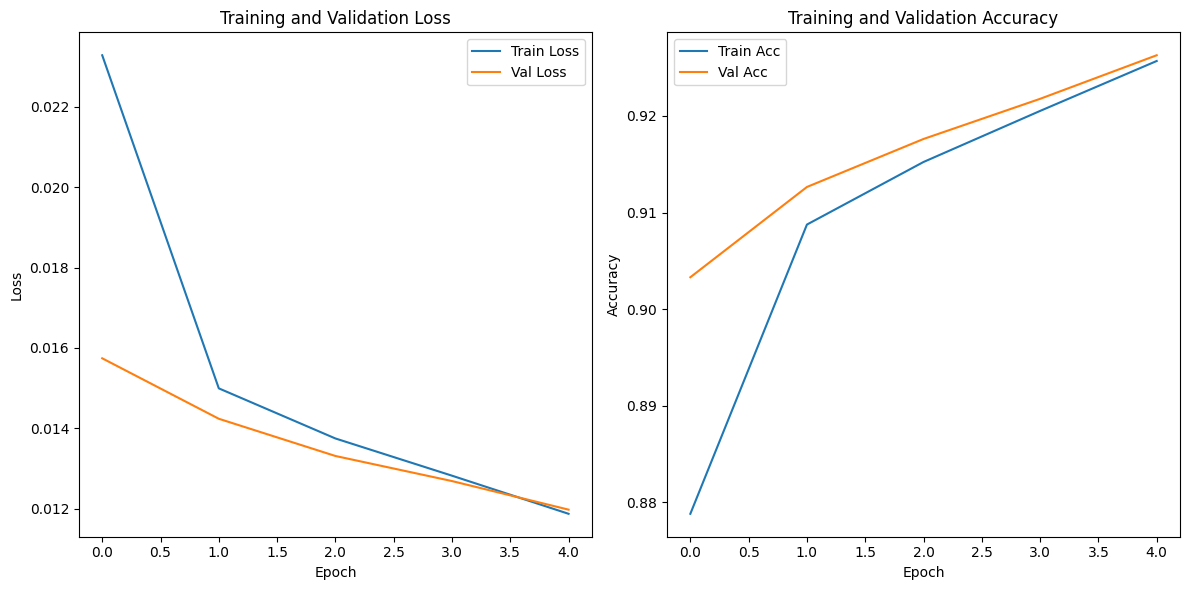

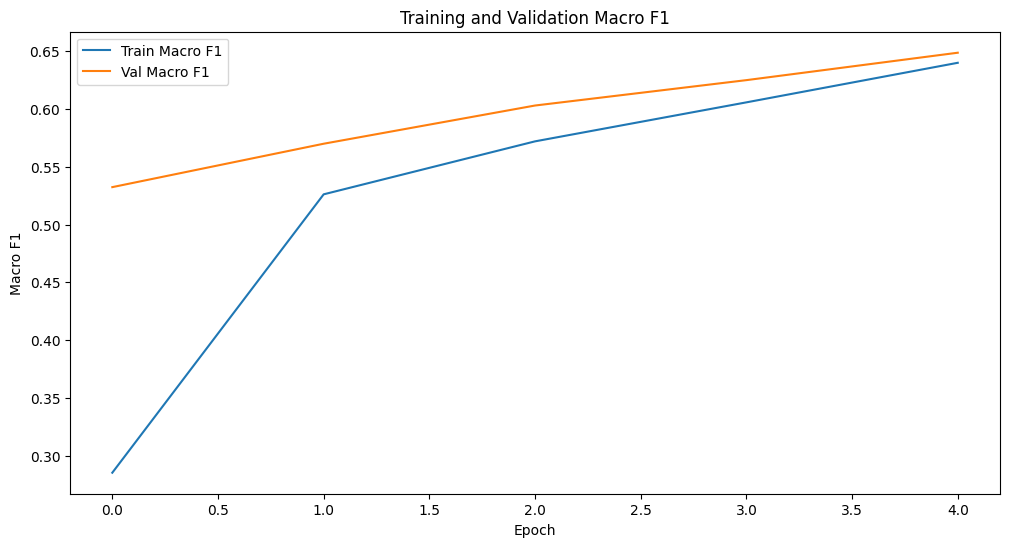

Optimal thresholds per genre: {'Action': np.float32(0.39462432), 'Adventure': np.float32(0.39632288), 'Animation': np.float32(0.4430329), 'Comedy': np.float32(0.39455873), 'Crime': np.float32(0.4407012), 'Documentary': np.float32(0.3875693), 'Drama': np.float32(0.47970933), 'Family': np.float32(0.39376482), 'Fantasy': np.float32(0.41600952), 'Foreign': np.float32(0.31646168), 'History': np.float32(0.44835812), 'Horror': np.float32(0.42329654), 'Music': np.float32(0.41288087), 'Mystery': np.float32(0.4073374), 'Romance': np.float32(0.4579164), 'Science Fiction': np.float32(0.4366921), 'TV Movie': np.float32(0.31591928), 'Thriller': np.float32(0.46530303), 'War': np.float32(0.51682913), 'Western': np.float32(0.3944344)}
Per-genre Test F1-scores: {'Action': np.float64(0.6453920220082531), 'Adventure': np.float64(0.5834084761045988), 'Animation': np.float64(0.7597222222222222), 'Comedy': np.float64(0.6608291636883489), 'Crime': np.float64(0.5491400491400491), 'Documentary': np.float64(0.82

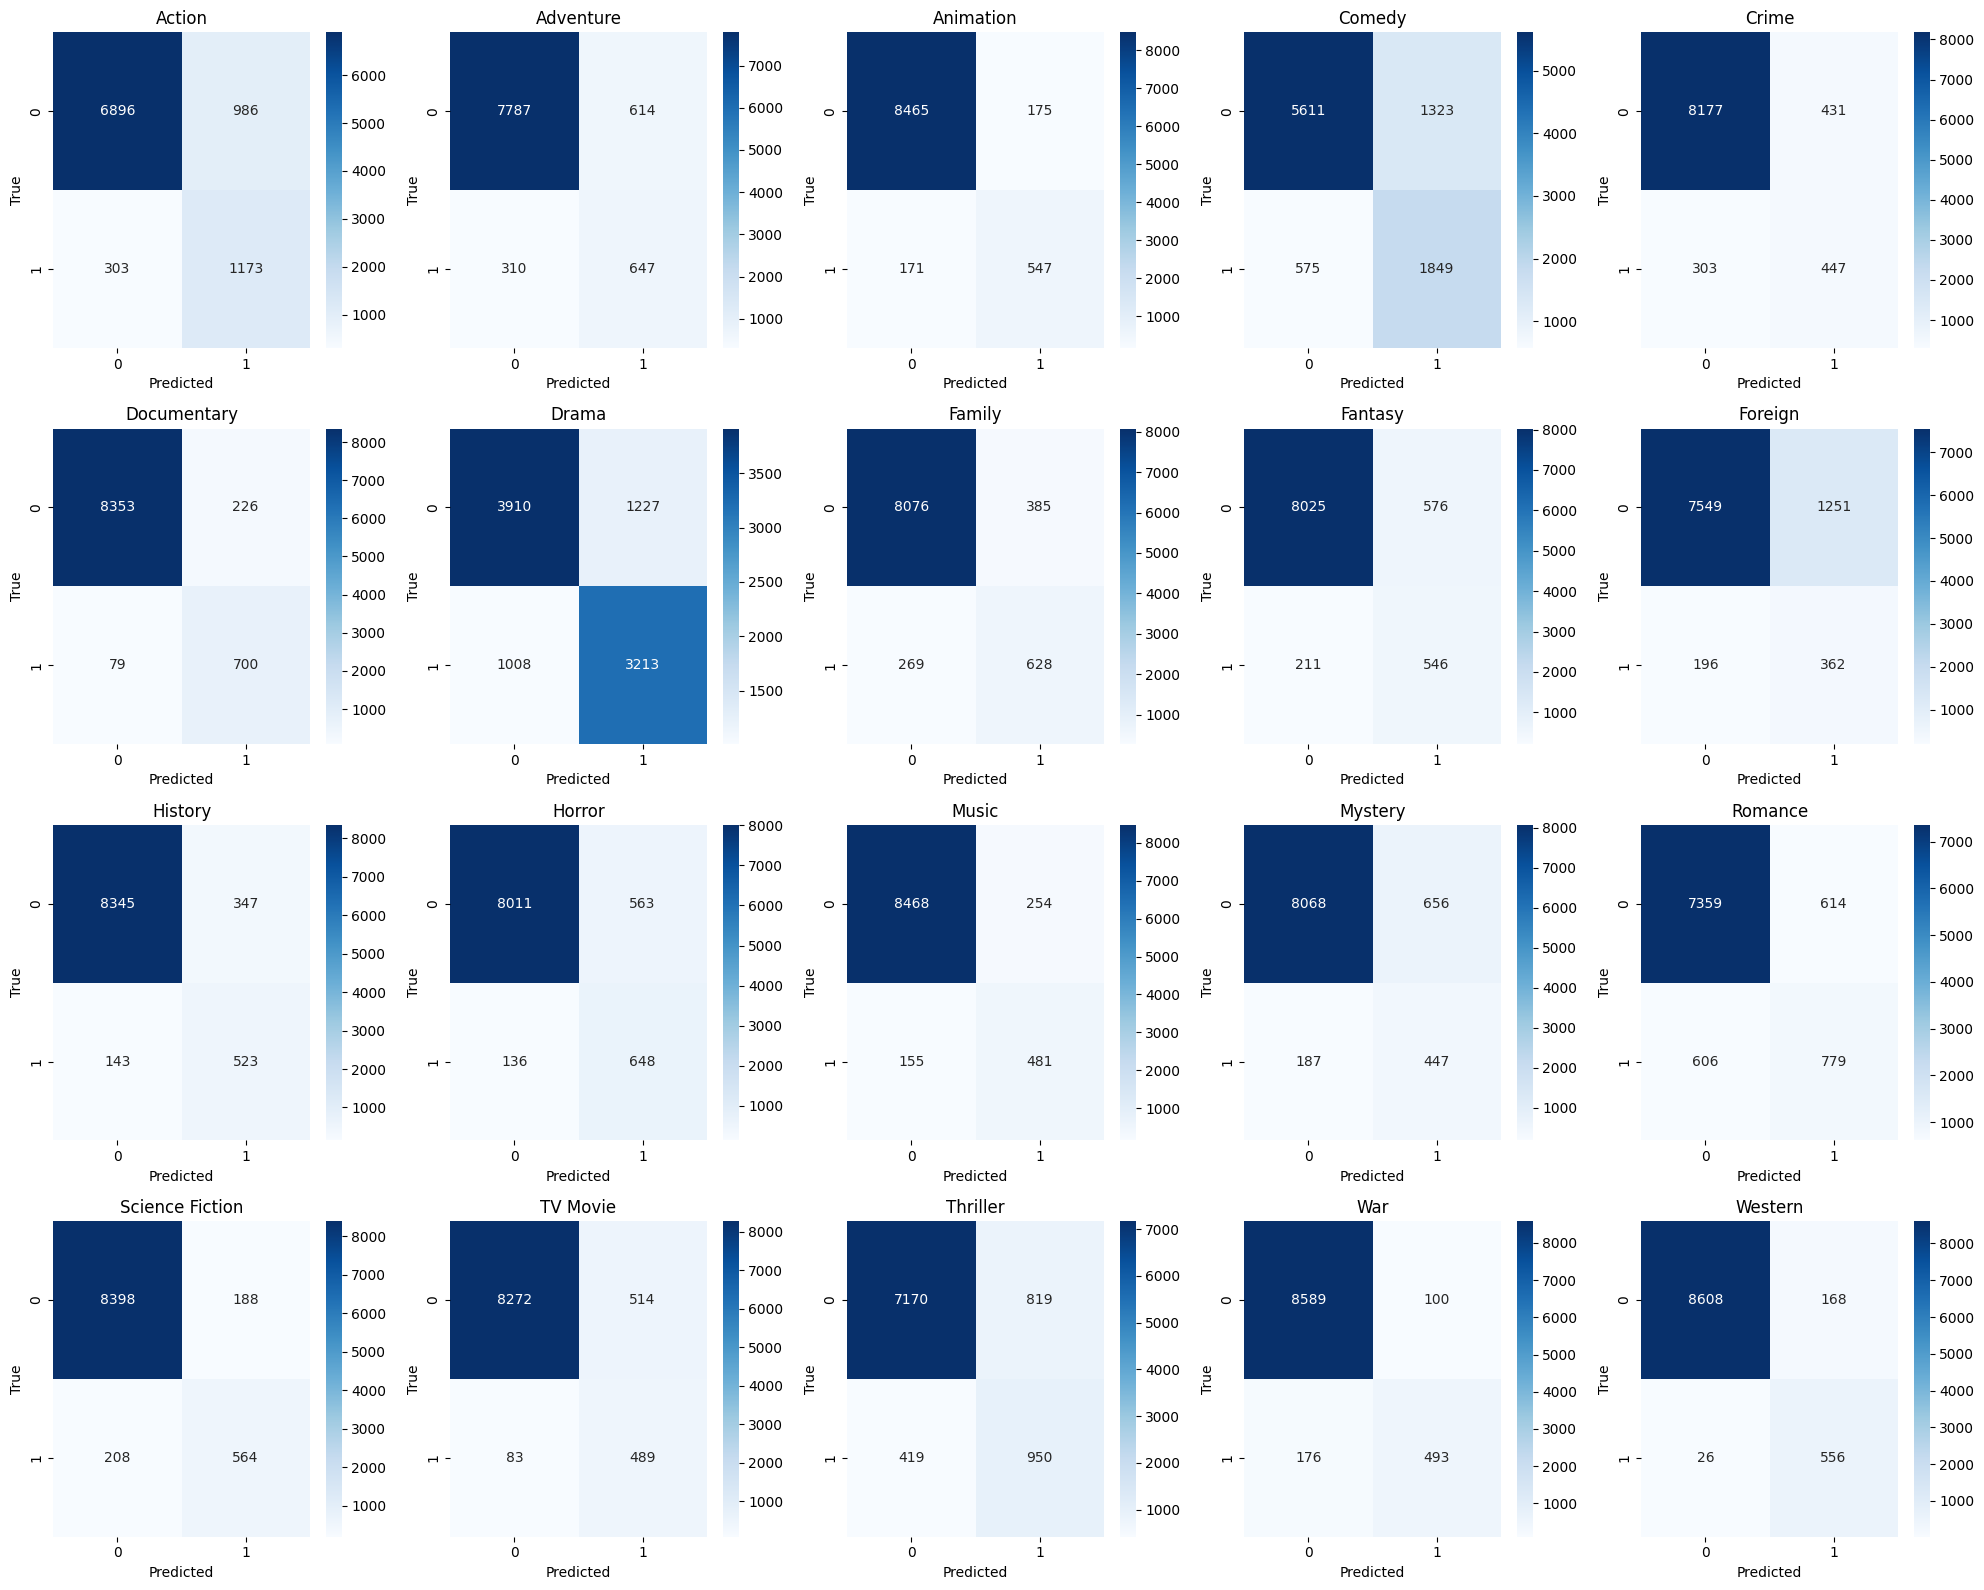

Predicted Genres for new overview: ['Adventure', 'Animation', 'Family', 'Fantasy']


In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import f1_score, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, AdamW
from tqdm import tqdm

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# 1. Load and preprocess the data
df = pd.read_csv('filtered_movies.csv', sep='|')
print(f"Dataset size after cleaning: {len(df)} rows")

# Define genres
genres = ['Action', 'Adventure', 'Animation', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Family', 'Fantasy', 'Foreign', 'History', 'Horror', 'Music', 
          'Mystery', 'Romance', 'Science Fiction', 'TV Movie', 'Thriller', 'War', 'Western']
print(f"Genres: {genres}")

# Convert genre strings to lists
df['Genre'] = df['Genre'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

# Multi-label binarizer for genres
mlb = MultiLabelBinarizer(classes=genres)
genre_labels = mlb.fit_transform(df['Genre'])
print(f"Encoded texts length: {len(genre_labels)}")

# 2. Load GPT-2 Tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token  # GPT-2 doesn't have a padding token by default, so we use EOS token
max_len = 128  # GPT-2 can handle longer sequences, but 128 should be sufficient for movie overviews

def tokenize_text(text):
    if isinstance(text, float) or text is None:
        text = ""
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,  # Add special tokens (BOS/EOS for GPT-2)
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'  # Return PyTorch tensors
    )
    return encoding['input_ids'].squeeze(), encoding['attention_mask'].squeeze()

# Tokenize the overviews
df['encoded'] = df['Overview'].apply(tokenize_text)

# Custom multi-label oversampling
encoded_np = np.array(df['encoded'].tolist())
genre_labels_np = np.array(genre_labels)

# Compute the frequency of each genre
genre_counts = np.sum(genre_labels_np, axis=0)
target_count = int(np.median(genre_counts) * 1.5)  # Target count for each genre (1.5x median)

# Oversample each genre independently
oversampled_indices = []
for genre_idx in range(len(genres)):
    genre_indices = np.where(genre_labels_np[:, genre_idx] == 1)[0]
    current_count = len(genre_indices)
    
    if current_count == 0:
        continue
    
    if current_count < target_count:
        oversample_size = target_count - current_count
        oversampled_genre_indices = np.random.choice(genre_indices, size=oversample_size, replace=True)
        oversampled_indices.extend(oversampled_genre_indices)

# Combine original indices with oversampled indices
all_indices = np.arange(len(encoded_np)).tolist() + oversampled_indices
encoded_resampled = encoded_np[all_indices]
genre_labels_resampled = genre_labels_np[all_indices]

# 3. Create PyTorch Dataset
class MovieDataset(Dataset):
    def __init__(self, encoded, labels):
        self.input_ids = [enc[0] for enc in encoded]
        self.attention_masks = [enc[1] for enc in encoded]
        self.labels = labels

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_masks[idx],
            'labels': torch.tensor(self.labels[idx], dtype=torch.float)
        }

# Split the resampled data
X_train, X_temp, y_train, y_temp = train_test_split(encoded_resampled, genre_labels_resampled, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

train_dataset = MovieDataset(X_train, y_train)
val_dataset = MovieDataset(X_val, y_val)
test_dataset = MovieDataset(X_test, y_test)

batch_size = 16  # Smaller batch size due to memory constraints
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

print(f"Train size: {len(train_dataset)}, Val size: {len(val_dataset)}, Test size: {len(test_dataset)}")

# 4. Load GPT-2 Model for Sequence Classification
model = GPT2ForSequenceClassification.from_pretrained(
    'gpt2',
    num_labels=len(genres),
    problem_type="multi_label_classification"
).to(device)

# Set padding token ID for GPT-2
model.config.pad_token_id = tokenizer.pad_token_id

# Freeze early layers to focus on genre-specific features
for param in model.transformer.h[:6].parameters():  # Freeze first 6 layers of GPT-2
    param.requires_grad = False

optimizer = AdamW(model.parameters(), lr=2e-5)  # Standard learning rate for fine-tuning GPT-2

# 5. Define Focal Loss
def focal_loss(logits, labels, alpha=0.25, gamma=2):
    bce_loss = nn.BCEWithLogitsLoss(reduction='none')(logits, labels)
    pt = torch.exp(-bce_loss)
    focal_loss = alpha * (1 - pt) ** gamma * bce_loss
    return focal_loss.mean()

# 6. Training Loop with Focal Loss and Adjusted Thresholds
def train_model(model, train_loader, val_loader, epochs=5):
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    train_f1s, val_f1s = [], []
    best_val_f1 = 0
    patience = 3
    epochs_no_improve = 0
    thresholds = [0.5] * len(genres)

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        train_correct = 0
        train_total = 0
        train_preds, train_labels = [], []

        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1} Training"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            loss = focal_loss(logits, labels, alpha=0.25, gamma=2)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            predicted = (torch.sigmoid(logits) > 0.5).float()
            train_total += labels.size(0)
            train_correct += (predicted == labels).float().mean().item() * labels.size(0)
            train_preds.append(torch.sigmoid(logits).detach().cpu().numpy())
            train_labels.append(labels.cpu().numpy())

        train_loss = train_loss / len(train_loader)
        train_acc = train_correct / train_total
        train_preds = np.vstack(train_preds)
        train_labels = np.vstack(train_labels)

        # Compute thresholds after first epoch (with bias for rare genres)
        if epoch == 0:
            val_preds, val_labels = [], []
            model.eval()
            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    outputs = model(input_ids, attention_mask=attention_mask)
                    logits = outputs.logits
                    val_preds.append(torch.sigmoid(logits).cpu().numpy())
                    val_labels.append(labels.cpu().numpy())
            val_preds = np.vstack(val_preds)
            val_labels = np.vstack(val_labels)
            class_counts = np.sum(genre_labels_resampled, axis=0)
            thresholds = []
            for i in range(len(genres)):
                precision, recall, thresh = precision_recall_curve(val_labels[:, i], val_preds[:, i])
                f1_scores = 2 * (precision * recall) / (precision + recall + 1e-10)
                if class_counts[i] < 500:
                    optimal_idx = np.argmax(precision * 0.7 + recall * 0.3)
                else:
                    optimal_idx = np.argmax(f1_scores)
                thresholds.append(thresh[optimal_idx] if optimal_idx < len(thresh) else 0.5)

        # Apply per-genre thresholds for training F1-score
        train_preds_adjusted = np.zeros_like(train_preds)
        for i in range(len(genres)):
            train_preds_adjusted[:, i] = (train_preds[:, i] > thresholds[i]).astype(float)
        train_f1 = f1_score(train_labels, train_preds_adjusted, average='macro')
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        train_f1s.append(train_f1)

        # Validation
        model.eval()
        val_loss = 0
        val_correct = 0
        val_total = 0
        val_preds, val_labels = [], []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} Validation"):
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits

                loss = focal_loss(logits, labels, alpha=0.25, gamma=2)
                val_loss += loss.item()

                predicted = (torch.sigmoid(logits) > 0.5).float()
                val_total += labels.size(0)
                val_correct += (predicted == labels).float().mean().item() * labels.size(0)
                val_preds.append(torch.sigmoid(logits).cpu().numpy())
                val_labels.append(labels.cpu().numpy())

        val_loss = val_loss / len(val_loader)
        val_acc = val_correct / val_total
        val_accs.append(val_acc)
        val_losses.append(val_loss)

        val_preds = np.vstack(val_preds)
        val_labels = np.vstack(val_labels)
        val_preds_adjusted = np.zeros_like(val_preds)
        for i in range(len(genres)):
            val_preds_adjusted[:, i] = (val_preds[:, i] > thresholds[i]).astype(float)
        
        val_f1 = f1_score(val_labels, val_preds_adjusted, average='macro')
        val_f1_per_genre = f1_score(val_labels, val_preds_adjusted, average=None)
        val_f1s.append(val_f1)

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train Macro F1: {train_f1:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val Macro F1: {val_f1:.4f}")
        print(f"Per-genre Val F1-scores: {dict(zip(genres, val_f1_per_genre))}")

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s, thresholds

# Train the model
train_losses, val_losses, train_accs, val_accs, train_f1s, val_f1s, thresholds = train_model(model, train_loader, val_loader)

# 7. Plot Training Metrics
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Plot F1-scores
plt.figure(figsize=(12, 6))
plt.plot(train_f1s, label='Train Macro F1')
plt.plot(val_f1s, label='Val Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.title('Training and Validation Macro F1')
plt.legend()
plt.show()

# 8. Print Optimal Thresholds
print(f"Optimal thresholds per genre: {dict(zip(genres, thresholds))}")

# 9. Evaluate on Test Set with Optimal Thresholds
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
test_preds, test_labels = [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        test_preds.append(torch.sigmoid(logits).cpu().numpy())
        test_labels.append(labels.cpu().numpy())

test_preds = np.vstack(test_preds)
test_labels = np.vstack(test_labels)

test_preds_adjusted = np.zeros_like(test_preds)
for i in range(len(genres)):
    test_preds_adjusted[:, i] = (test_preds[:, i] > thresholds[i]).astype(float)

f1_scores = f1_score(test_labels, test_preds_adjusted, average=None)
macro_f1 = f1_score(test_labels, test_preds_adjusted, average='macro')
print(f"Per-genre Test F1-scores: {dict(zip(genres, f1_scores))}")
print(f"Test Macro-averaged F1-score: {macro_f1:.4f}")

# 10. Confusion Matrix for Each Genre
fig, axes = plt.subplots(4, 5, figsize=(20, 16))
axes = axes.ravel()

for i, genre in enumerate(genres):
    cm = np.zeros((2, 2))
    for j in range(len(test_labels)):
        true_label = int(test_labels[j][i])
        pred_label = int(test_preds_adjusted[j][i])
        cm[true_label][pred_label] += 1
    
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues', ax=axes[i])
    axes[i].set_title(genre)
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('True')

plt.tight_layout()
plt.show()

# 11. Example Prediction
def predict_genres(overview, model, tokenizer, max_len=max_len, thresholds=thresholds):
    model.eval()
    if isinstance(overview, float) or overview is None:
        overview = ""
    encoding = tokenizer.encode_plus(
        overview,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        prediction = torch.sigmoid(logits).cpu().numpy()[0]
    
    predicted = np.zeros_like(prediction)
    for i in range(len(genres)):
        predicted[i] = 1 if prediction[i] > thresholds[i] else 0
    predicted_genres = [genres[i] for i in range(len(predicted)) if predicted[i] == 1]
    return predicted_genres

# Example usage
new_overview = "A young boy discovers a magical world filled with dragons and knights, embarking on an epic quest to save his family."
predicted_genres = predict_genres(new_overview, model, tokenizer)
print(f"Predicted Genres for new overview: {predicted_genres}")

multi modal

fix accuracy

✅ Using device: mps


/Users/kumarsatyam/python/basicsofai/project/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/kumarsatyam/python/basicsofai/project/.venv/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch    Train Acc    Val Acc     
------------------------------
1        70.61%     77.61%
2        77.69%     81.05%
3        79.21%     81.10%
4        80.03%     82.38%
5        80.70%     81.18%
6        81.23%     82.90%


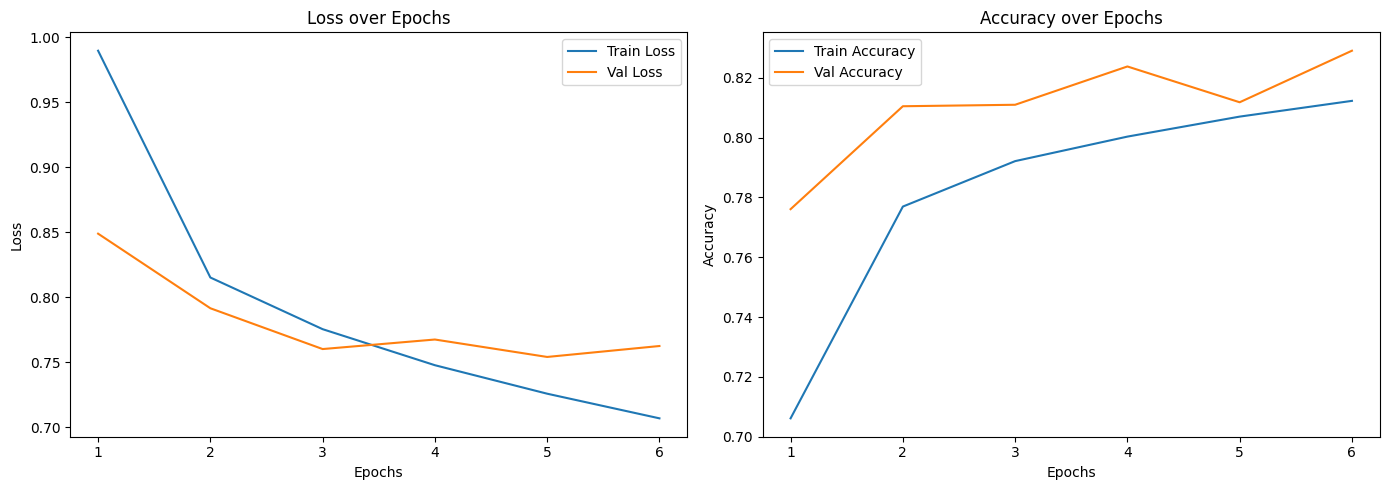


🎯 Tuning thresholds per genre:
Action             → Best Threshold: 0.55 | F1: 0.564
Adventure          → Best Threshold: 0.70 | F1: 0.430
Animation          → Best Threshold: 0.85 | F1: 0.541
Comedy             → Best Threshold: 0.55 | F1: 0.659
Crime              → Best Threshold: 0.80 | F1: 0.509
Documentary        → Best Threshold: 0.85 | F1: 0.800
Drama              → Best Threshold: 0.30 | F1: 0.741
Family             → Best Threshold: 0.85 | F1: 0.497
Fantasy            → Best Threshold: 0.70 | F1: 0.413
Foreign            → Best Threshold: 0.60 | F1: 0.201
History            → Best Threshold: 0.90 | F1: 0.378
Horror             → Best Threshold: 0.80 | F1: 0.618
Music              → Best Threshold: 0.75 | F1: 0.493
Mystery            → Best Threshold: 0.75 | F1: 0.357
Romance            → Best Threshold: 0.55 | F1: 0.520
Science Fiction    → Best Threshold: 0.75 | F1: 0.586
TV Movie           → Best Threshold: 0.90 | F1: 0.205
Thriller           → Best Threshold: 0.65 | F1: 0.

/Users/kumarsatyam/python/basicsofai/project/.venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


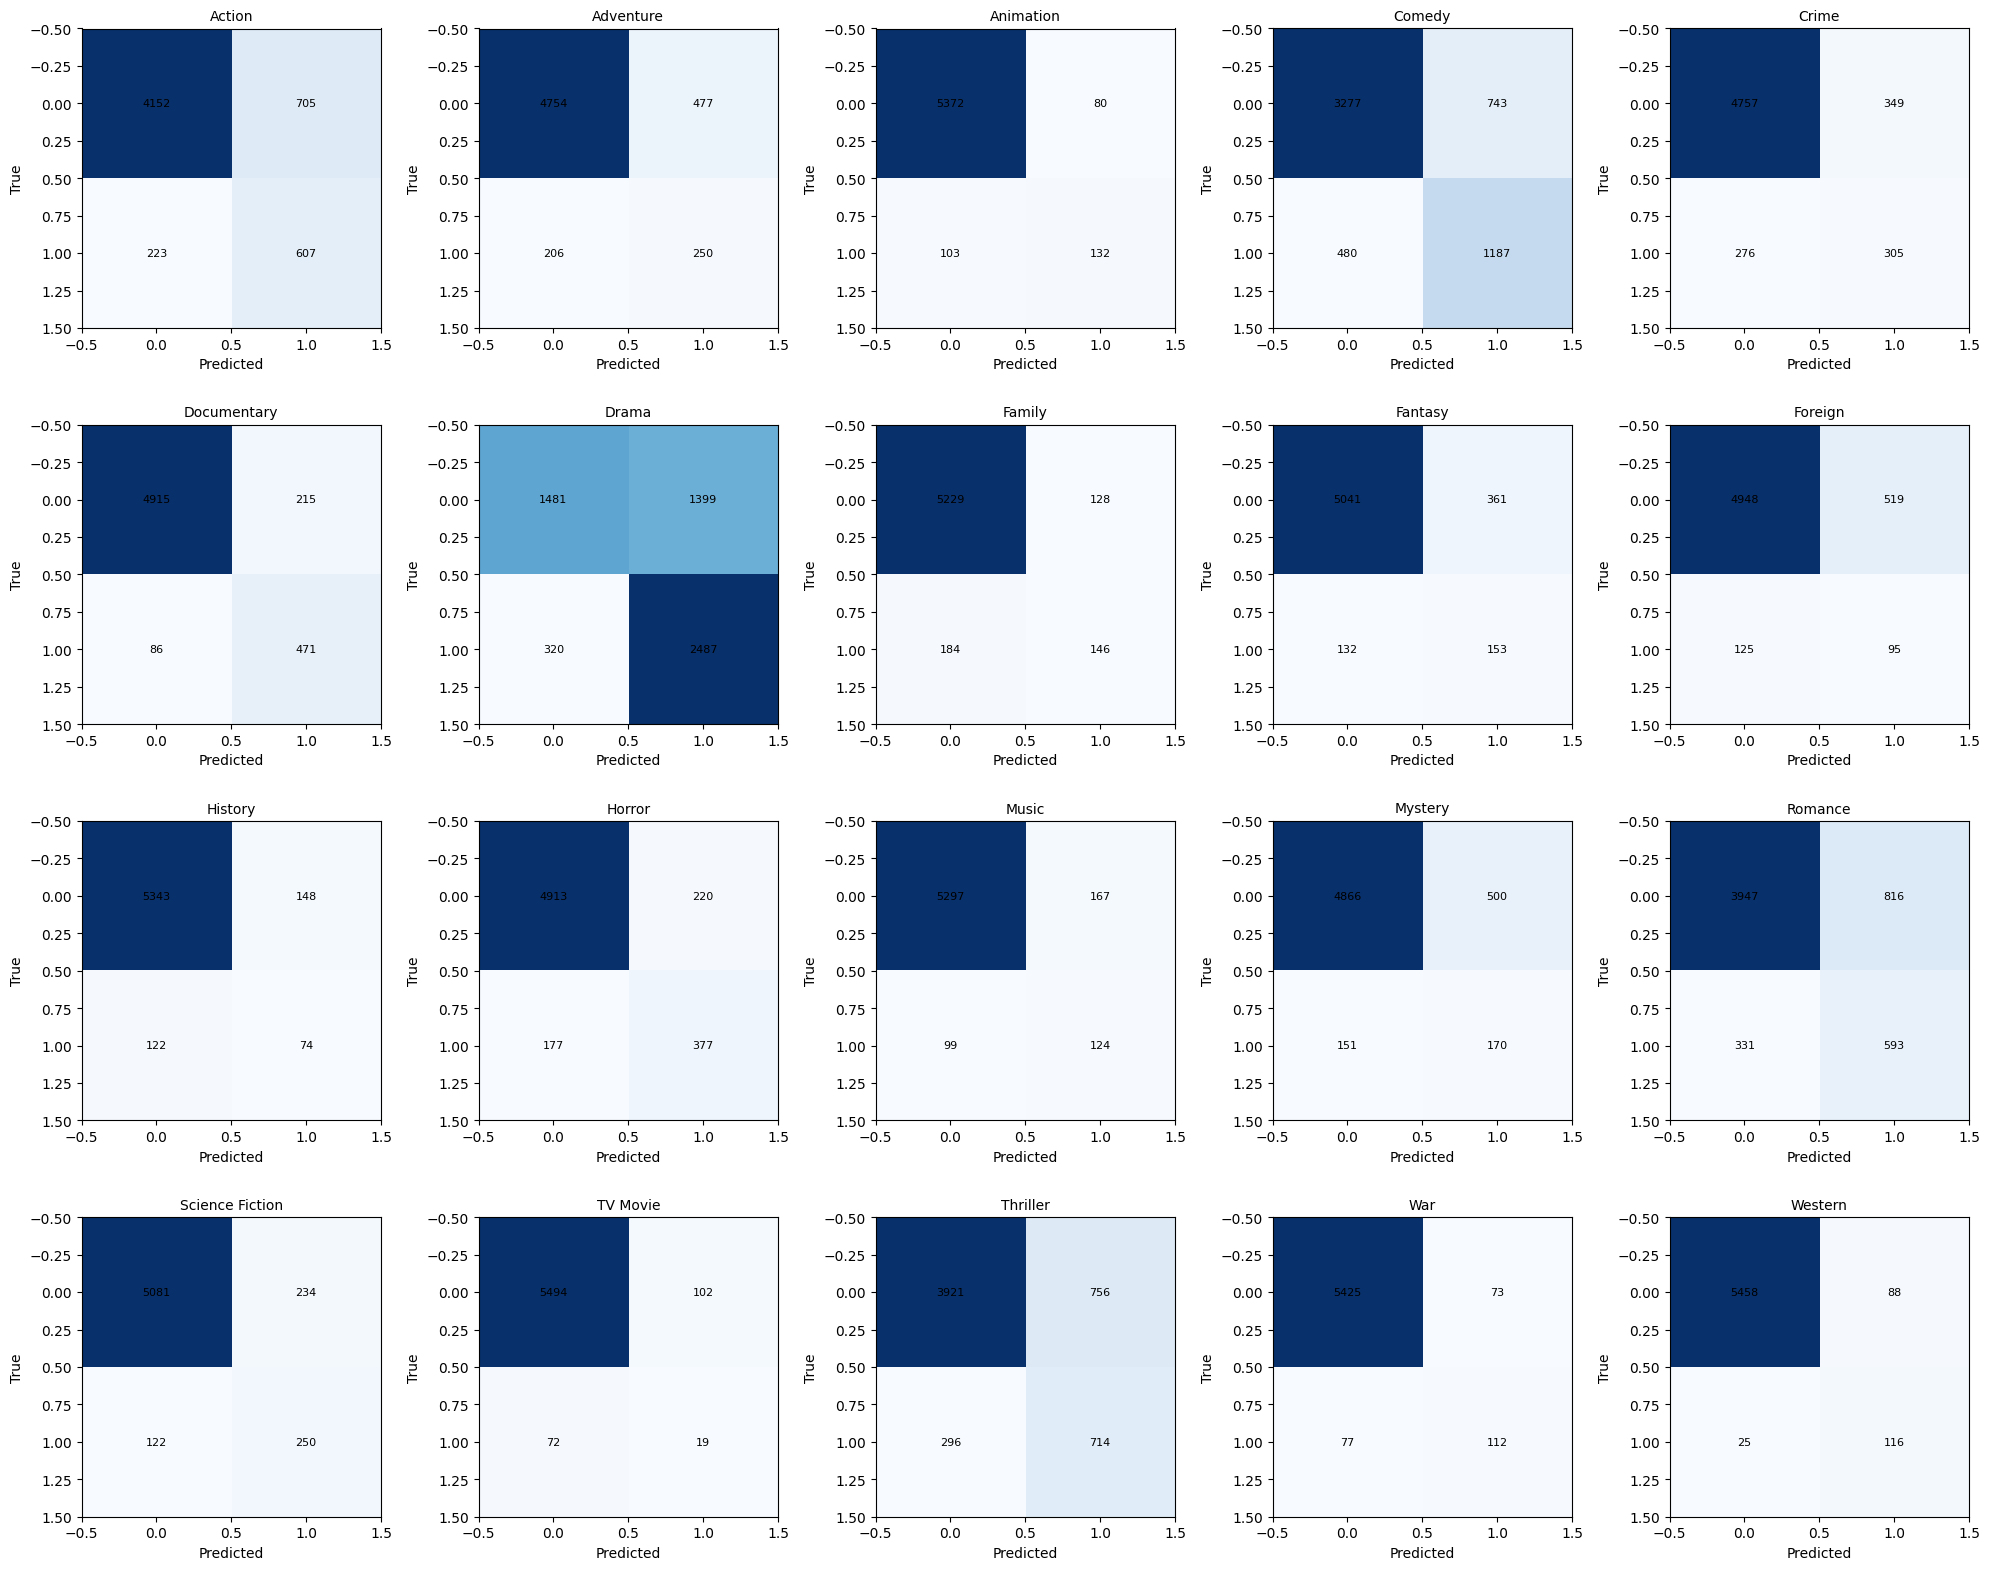

💾 Model saved to 'multimodal_genre_classifier.pth'


In [ ]:
# --- All necessary imports ---
import os
import io
import gc
import torch
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from torchvision import transforms
from torchvision.models import resnet50
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
from tqdm import tqdm
import PIL
PIL.Image.MAX_IMAGE_PIXELS = None

# --- CONFIGURATION ---
CSV_PATH = "filtered_movies.csv"  
CACHE_DIR = "./cached_preprocessed"  
os.makedirs(CACHE_DIR, exist_ok=True)

IMG_SIZE = 224
MAX_LEN = 128
BATCH_SIZE = 8
EPOCHS = 6
LR = 1e-4

# --- DEVICE SETUP (MPS / CUDA / CPU) ---
if torch.backends.mps.is_available():
    DEVICE = "mps"
elif torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

print(f"✅ Using device: {DEVICE}")

# --- TRANSFORMS ---
image_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# --- MODEL ---
class MultimodalGenreClassifier(nn.Module):
    def __init__(self, num_genres):
        super().__init__()
        self.text_fc = nn.Linear(768, 256)
        cnn_base = resnet50(pretrained=True)
        self.cnn = nn.Sequential(*list(cnn_base.children())[:-1])
        self.image_fc = nn.Linear(2048, 256)
        self.classifier = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_genres)
        )

    def forward(self, text_feat, image):
        text_feat = text_feat.float()
        image = image.float()
        text_feat = self.text_fc(text_feat)
        image_feat = self.cnn(image)
        image_feat = image_feat.view(image_feat.size(0), -1)
        image_feat = self.image_fc(image_feat)
        combined = torch.cat((text_feat, image_feat), dim=1)
        return self.classifier(combined)

# --- DATASET ---
class LazyCachedMovieDataset(Dataset):
    def __init__(self, cache_dir):
        self.cache_dir = cache_dir
        self.cache_files = []
        self.offsets = []
        self.total_len = 0

        for file in sorted(os.listdir(cache_dir)):
            if file.endswith(".pt"):
                path = os.path.join(cache_dir, file)
                data = torch.load(path, map_location="cpu")
                chunk_size = len(data["texts"])
                self.cache_files.append(path)
                self.offsets.append((self.total_len, self.total_len + chunk_size))
                self.total_len += chunk_size

        all_labels = []
        for path in self.cache_files:
            data = torch.load(path, map_location="cpu")
            all_labels.extend(data["labels"])
        self.mlb = MultiLabelBinarizer()
        self.mlb.fit(all_labels)

    def __len__(self):
        return self.total_len

    def __getitem__(self, idx):
        for chunk_idx, (start, end) in enumerate(self.offsets):
            if start <= idx < end:
                path = self.cache_files[chunk_idx]
                data = torch.load(path, map_location="cpu")
                local_idx = idx - start
                text = data["texts"][local_idx].float()
                image = data["images"][local_idx].float()
                label = torch.tensor(self.mlb.transform([data["labels"][local_idx]])[0], dtype=torch.float)
                return {"text": text, "image": image, "label": label}
        raise IndexError(f"Index {idx} out of range.")

# --- UTILS ---
def custom_collate_fn(batch):
    texts = torch.stack([item["text"] for item in batch])
    images = torch.stack([item["image"] for item in batch])
    labels = torch.stack([item["label"] for item in batch])
    return texts, images, labels

def compute_pos_weights(label_matrix):
    pos_counts = label_matrix.sum(axis=0)
    neg_counts = label_matrix.shape[0] - pos_counts
    pos_weights = neg_counts / (pos_counts + 1e-5)
    return torch.tensor(pos_weights, dtype=torch.float)

def plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses)+1)
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs, train_accs, label="Train Accuracy")
    plt.plot(epochs, val_accs, label="Val Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Accuracy over Epochs")
    plt.legend()

    plt.tight_layout()
    plt.show()

def plot_confusion_matrices(all_preds, all_targets, genre_labels):
    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    axes = axes.flatten()
    for idx, label in enumerate(genre_labels):
        cm = confusion_matrix(all_targets[:, idx], all_preds[:, idx])
        ax = axes[idx]
        ax.imshow(cm, cmap="Blues")
        ax.set_title(label, fontsize=10)
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')
        for i in range(2):
            for j in range(2):
                ax.text(j, i, cm[i, j], ha='center', va='center', color='black', fontsize=8)
    plt.tight_layout()
    plt.show()

# --- PREPROCESSING ---
def preprocess_and_cache():
    print("🔄 Preprocessing BERT and image features in chunks...")
    tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
    bert = BertModel.from_pretrained("bert-base-uncased").to(DEVICE)
    bert.eval()

    use_half = (DEVICE == "cuda")
    df = pd.read_csv(CSV_PATH, delimiter="|").dropna(subset=["Overview", "Poster_Url", "Genre"])
    df["Genres"] = df["Genre"].apply(lambda x: [g.strip() for g in x.split(",")])

    text_features, image_features, labels = [], [], []
    chunk_size = 100
    chunk_id = 0

    for idx, row in tqdm(df.iterrows(), total=len(df)):
        try:
            inputs = tokenizer(row["Overview"], return_tensors="pt", padding="max_length",
                               truncation=True, max_length=MAX_LEN).to(DEVICE)
            with torch.no_grad():
                text_emb = bert(**inputs).last_hidden_state[:, 0, :].squeeze(0).cpu()
            if use_half:
                text_emb = text_emb.half()

            try:
                response = requests.get(row["Poster_Url"], timeout=10)
                img = Image.open(io.BytesIO(response.content)).convert("RGB")
                img.thumbnail((IMG_SIZE, IMG_SIZE))
                image_tensor = image_transform(img)
            except:
                image_tensor = torch.randn(3, IMG_SIZE, IMG_SIZE)

            if use_half:
                image_tensor = image_tensor.half()

            text_features.append(text_emb)
            image_features.append(image_tensor)
            labels.append(row["Genres"])

            if len(text_features) >= chunk_size:
                torch.save({
                    "texts": torch.stack(text_features),
                    "images": torch.stack(image_features),
                    "labels": labels
                }, os.path.join(CACHE_DIR, f"chunk_{chunk_id}.pt"))
                chunk_id += 1
                text_features, image_features, labels = [], [], []
                gc.collect()

        except Exception as e:
            print(f"⚠️ Skipping row {idx} due to error: {e}")

    if text_features:
        torch.save({
            "texts": torch.stack(text_features),
            "images": torch.stack(image_features),
            "labels": labels
        }, os.path.join(CACHE_DIR, f"chunk_{chunk_id}.pt"))

    print(f"✅ Preprocessing complete. Chunks saved to: {CACHE_DIR}/")

# --- MAIN ---
def main():
    if not any(f.endswith(".pt") for f in os.listdir(CACHE_DIR)):
        preprocess_and_cache()

    dataset = LazyCachedMovieDataset(CACHE_DIR)

    indices = list(range(len(dataset)))
    train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
    val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

    train_set = Subset(dataset, train_idx)
    val_set = Subset(dataset, val_idx)
    test_set = Subset(dataset, test_idx)

    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn, num_workers=0)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, num_workers=0)

    model = MultimodalGenreClassifier(num_genres=len(dataset.mlb.classes_)).to(DEVICE)

    all_labels = []
    for chunk_file in dataset.cache_files:
        chunk_data = torch.load(chunk_file, map_location="cpu")
        all_labels.extend(chunk_data["labels"])
    label_matrix = dataset.mlb.transform(all_labels)
    pos_weights = compute_pos_weights(label_matrix).to(DEVICE)

    loss_fn = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

    train_losses, val_losses, train_accs, val_accs = [], [], [], []

    print(f"\n{'Epoch':<8} {'Train Acc':<12} {'Val Acc':<12}")
    print("-" * 30)
    for epoch in range(EPOCHS):
        train_loss, train_acc = train_step(model, train_loader, optimizer, loss_fn)
        val_loss, val_acc = eval_step(model, val_loader, loss_fn)
        print(f"{epoch+1:<8} {train_acc:.2%}     {val_acc:.2%}")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

    plot_loss_accuracy(train_losses, val_losses, train_accs, val_accs)

    thresholds = tune_thresholds(model, val_loader, DEVICE, dataset.mlb.classes_)

    # Test evaluation
    all_preds, all_targets = [], []
    model.eval()
    with torch.no_grad():
        for text, images, labels in test_loader:
            text, images = text.to(DEVICE), images.to(DEVICE)
            outputs = model(text, images)
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = np.zeros_like(probs)
            for i, thresh in enumerate(thresholds):
                preds[:, i] = probs[:, i] > thresh
            all_preds.append(preds)
            all_targets.append(labels.numpy())

    all_preds = np.vstack(all_preds)
    all_targets = np.vstack(all_targets)

    print("\n📋 Final Test Report:")
    print(classification_report(all_targets, all_preds, target_names=dataset.mlb.classes_))

    plot_confusion_matrices(all_preds, all_targets, dataset.mlb.classes_)

    torch.save(model.state_dict(), "multimodal_genre_classifier.pth")
    print("💾 Model saved to 'multimodal_genre_classifier.pth'")

if __name__ == "__main__":
    main()
